In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import fitting_grids as fg


from matplotlib import cm
from scipy import stats
from math import atan, sin, cos
from scipy.signal import find_peaks

In [2]:
# points = np.genfromtxt("./data/coords.csv", delimiter=",")
df = pd.read_csv("./data/Xi/xi-coords-selected.csv",header=0,index_col=0)
points = df.values[:,0:2]

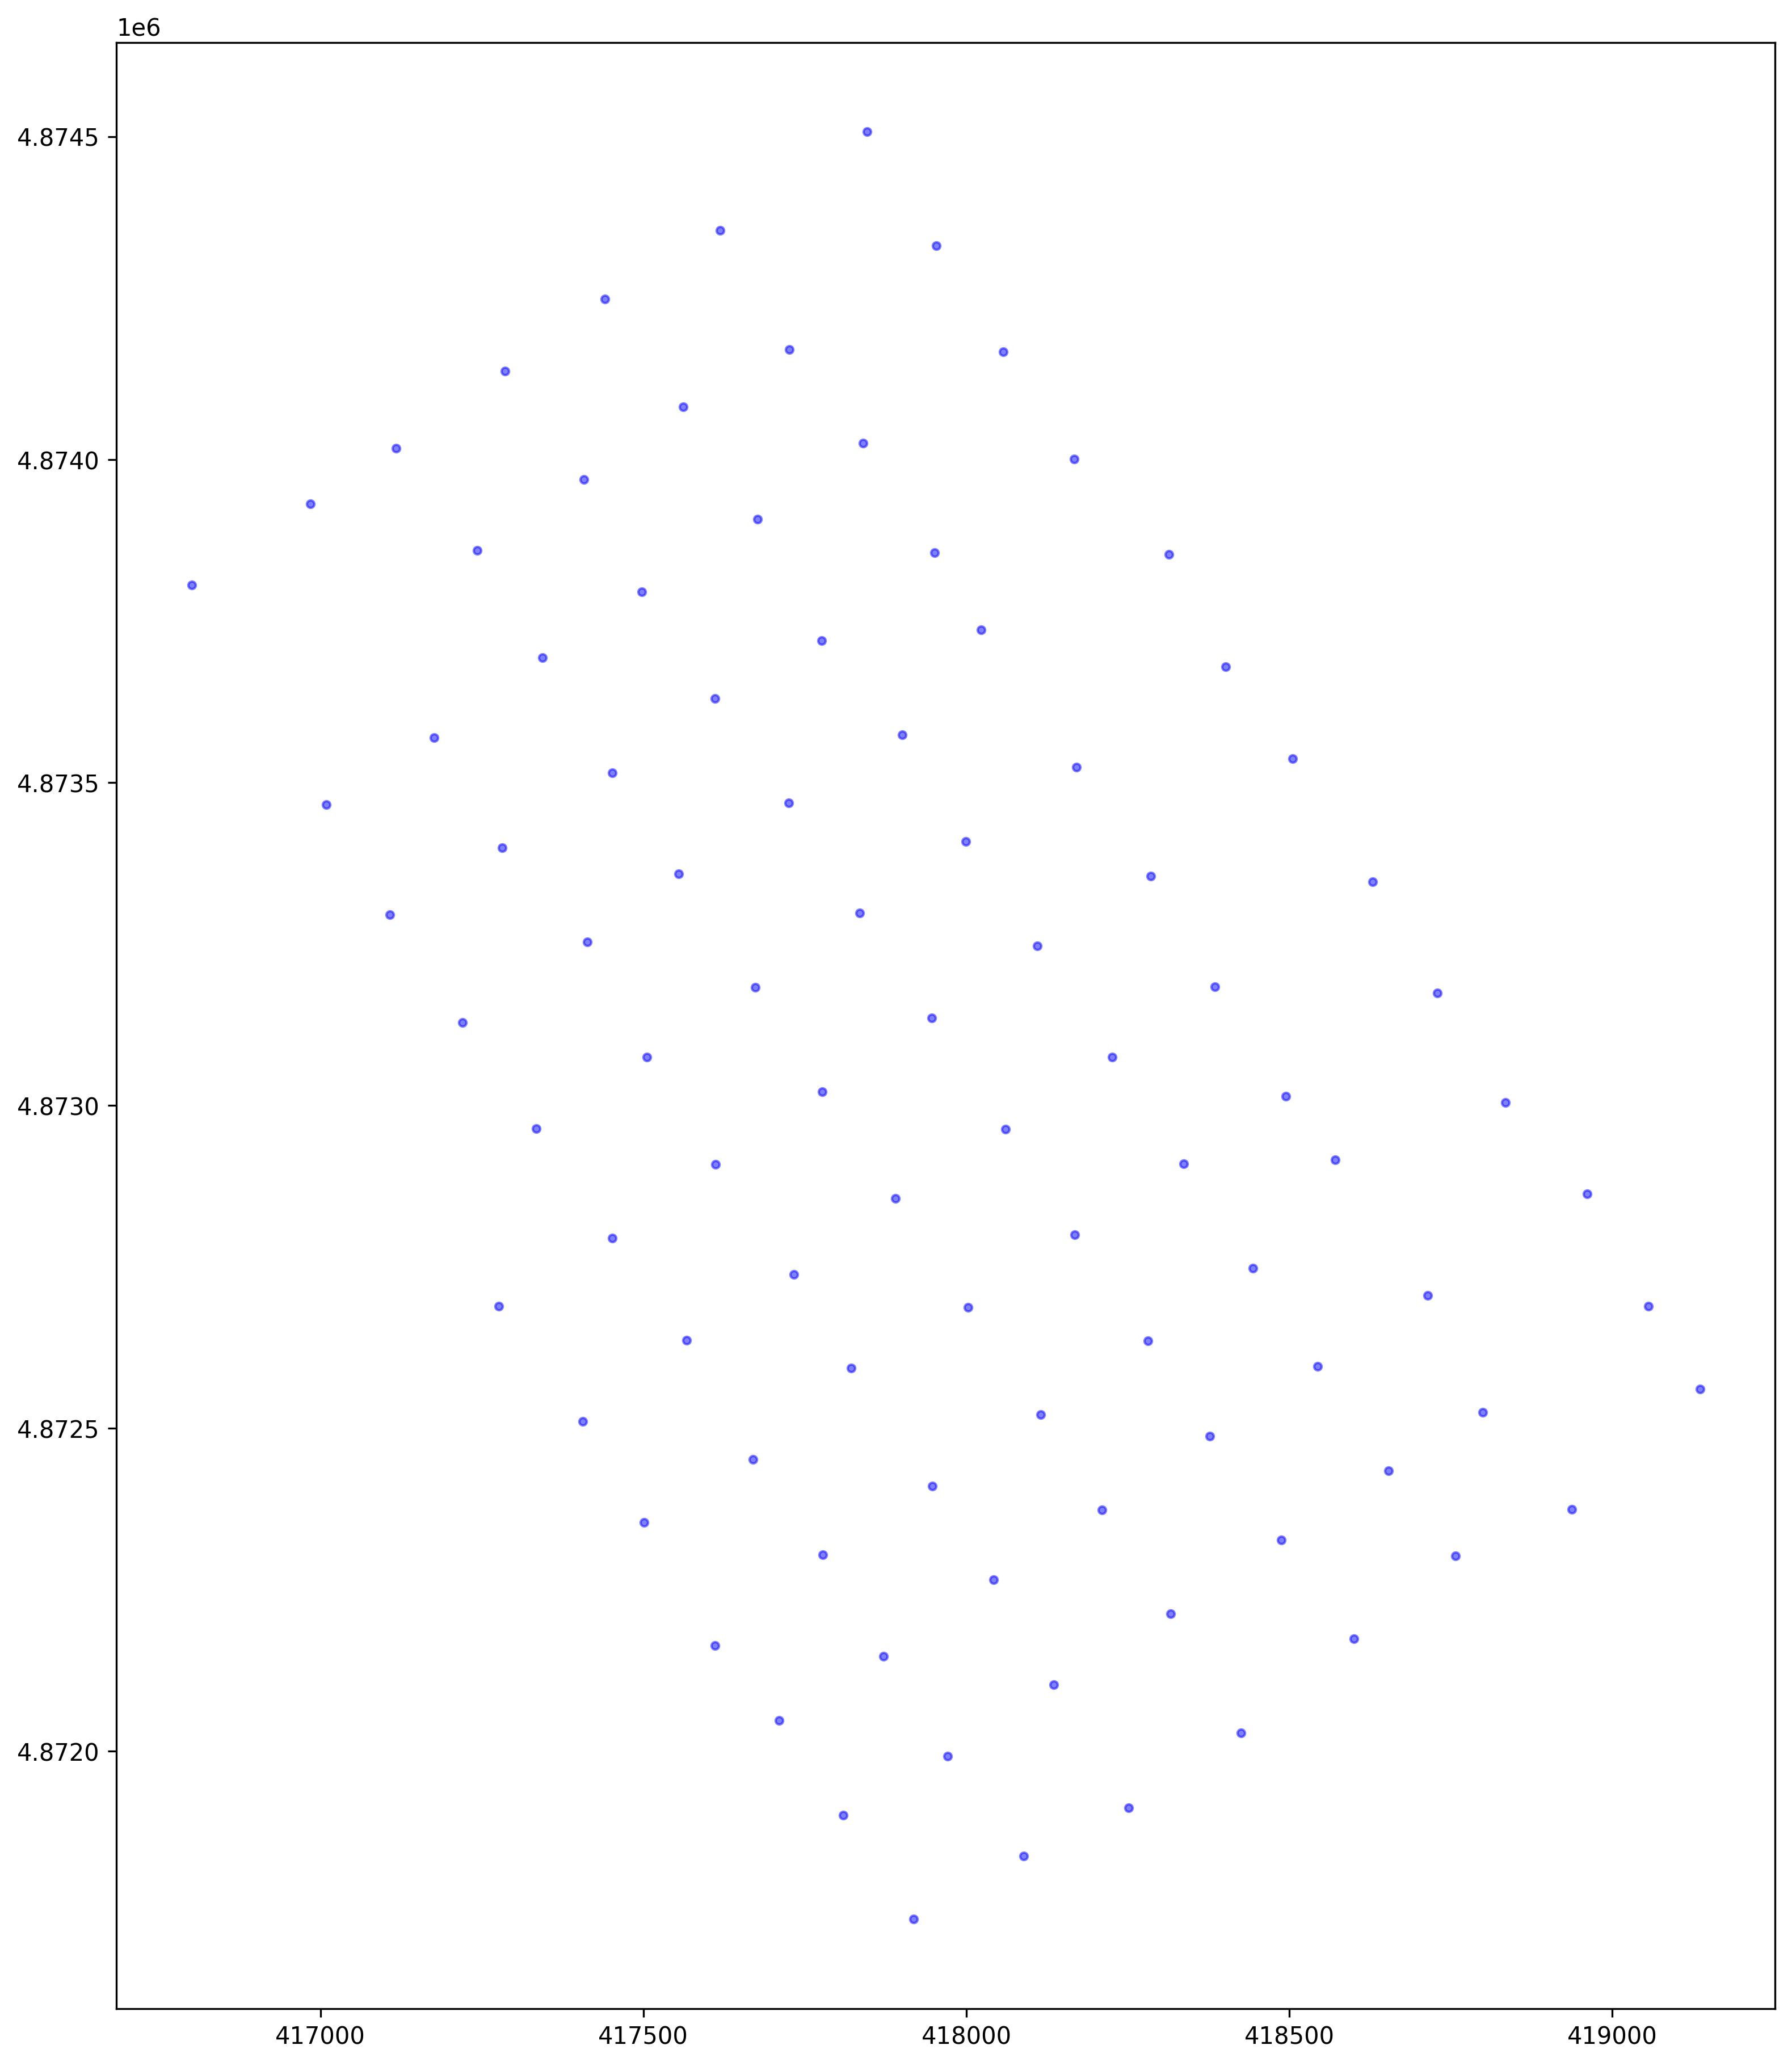

In [3]:
# fig, ax = plt.subplots(figsize=(15, 15),dpi=300)
# ax.set_aspect('equal')
# ax.scatter(points[:,0], points[:,1], s=10, c='b', alpha=0.5)
plt.figure(figsize=(15, 15),dpi=300)
plt.gca().set_aspect('equal')
plt.scatter(points[:,0], points[:,1], s=10, c='b', alpha=0.5)

#### 1. **平移**所有钻孔点至坐标原点

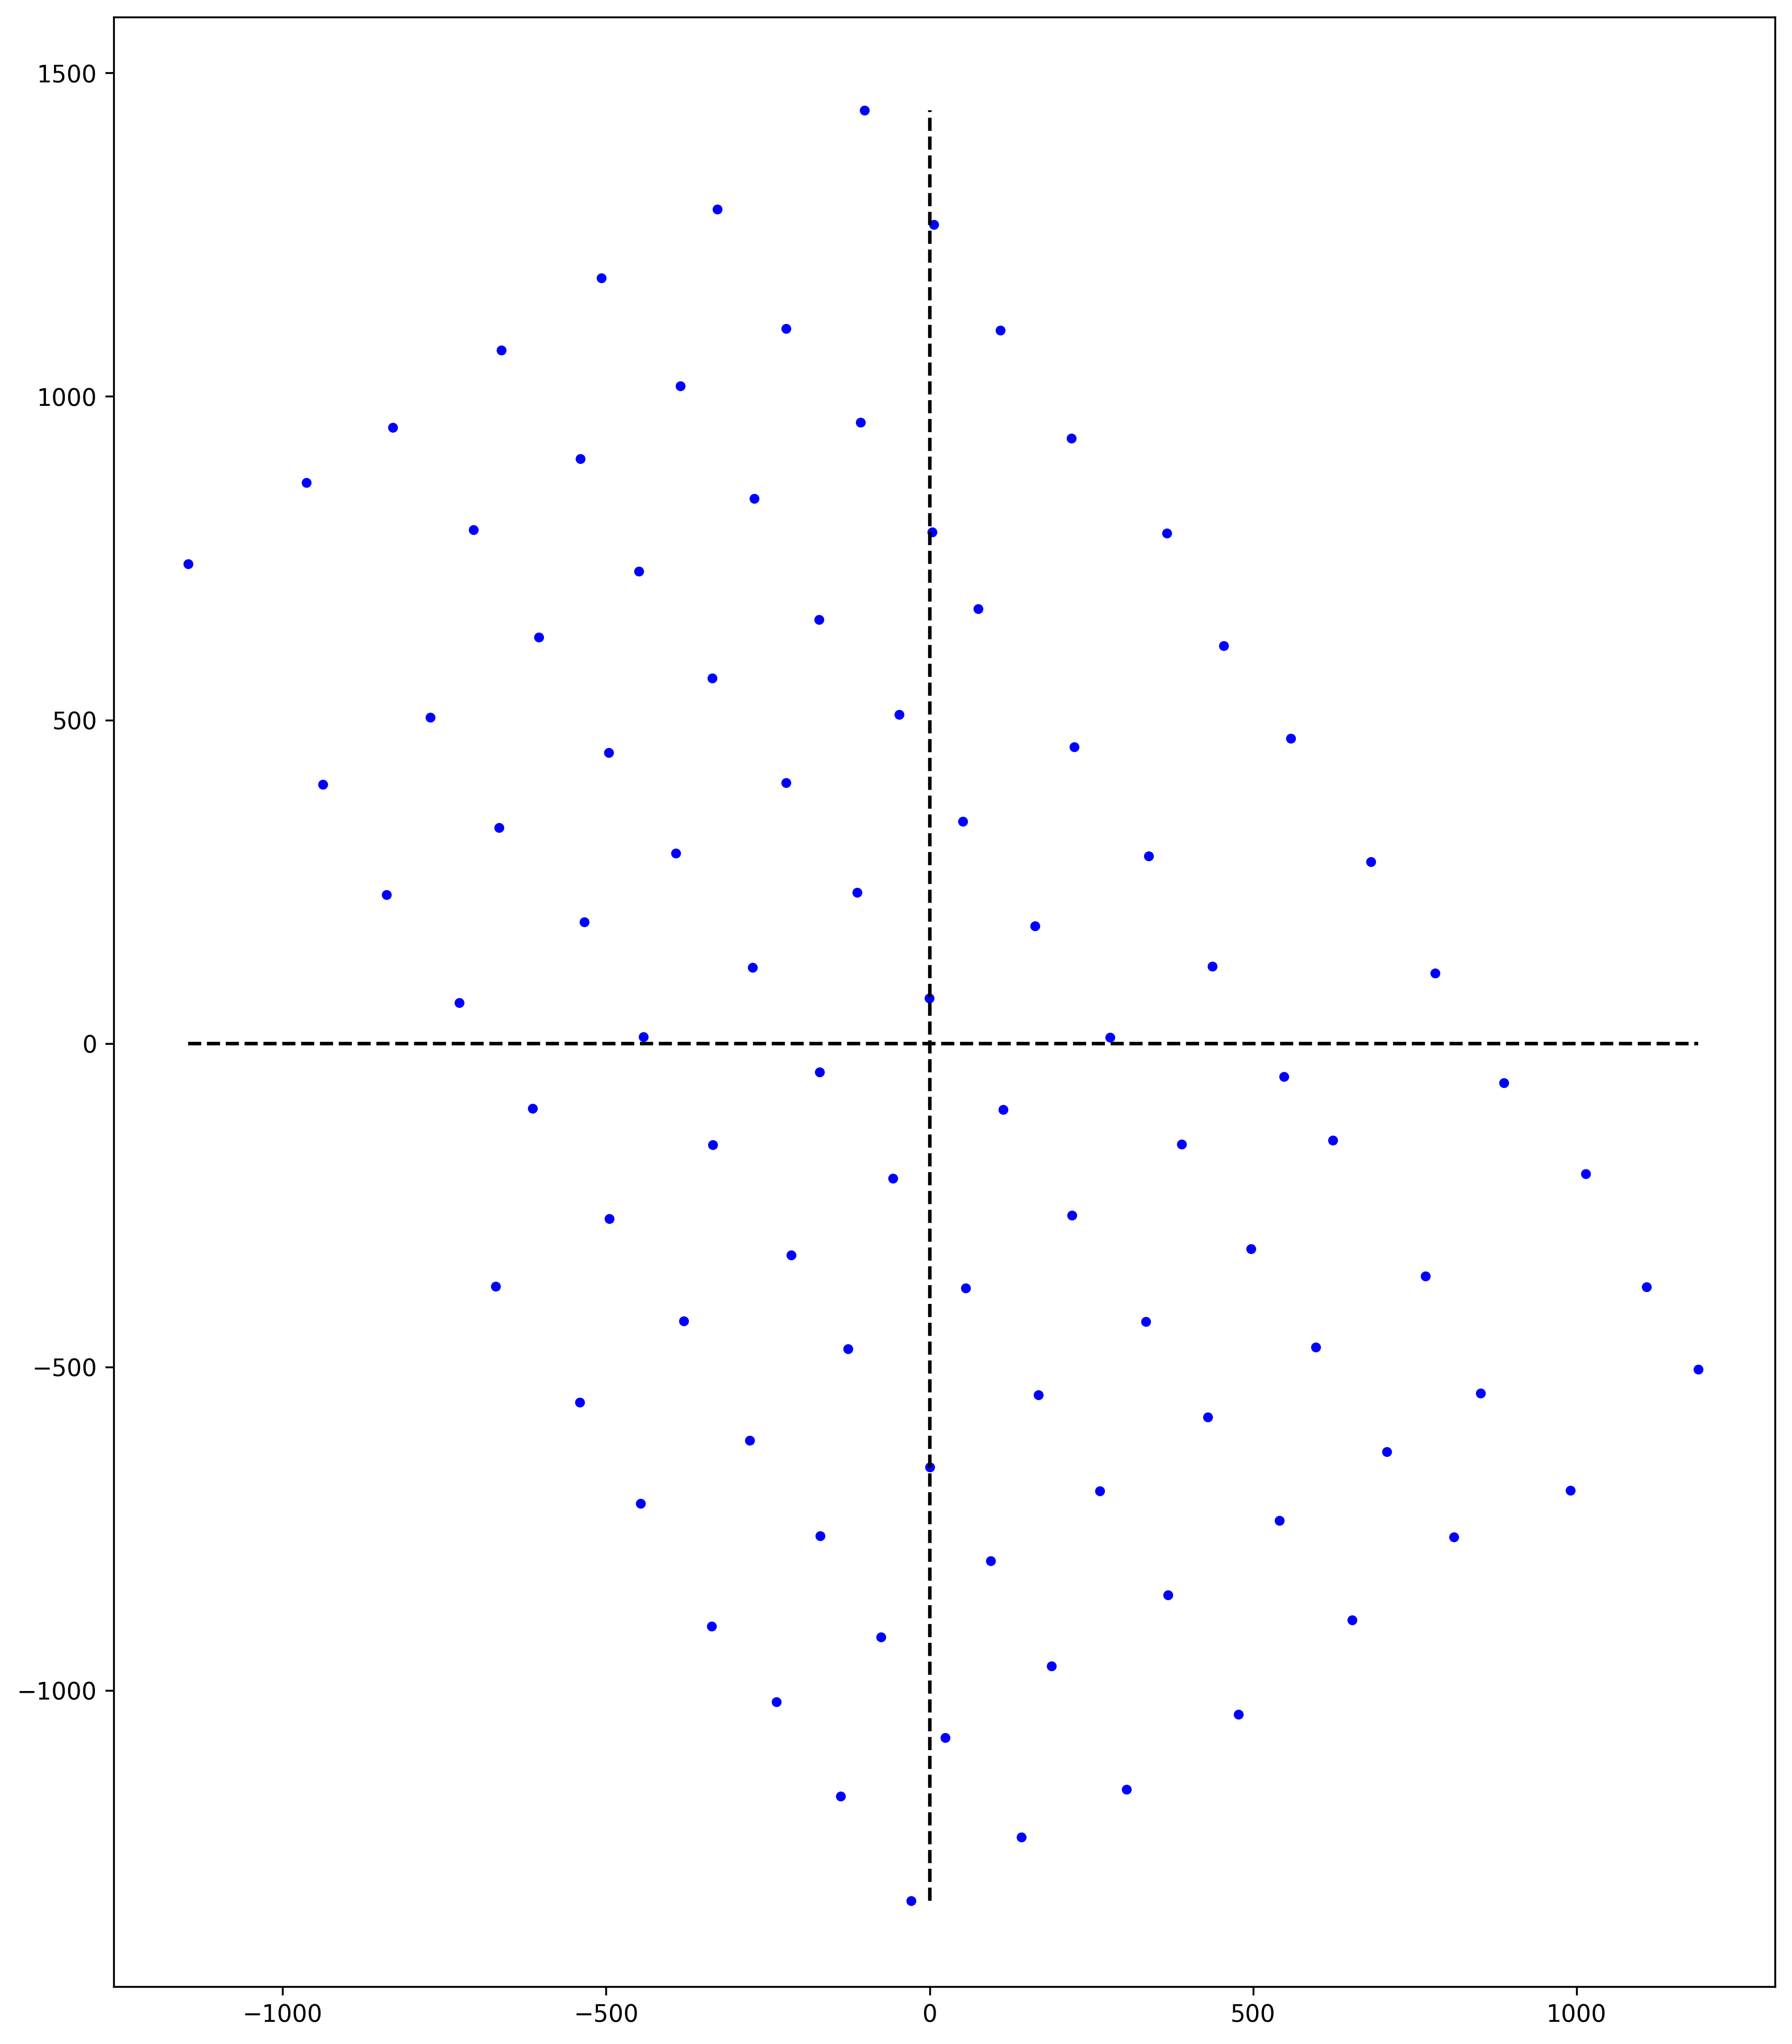

In [4]:
centre = np.mean(points, axis=0)
points_centered = points - centre

points_centered_x_min = points_centered[:,0].min()-abs(points_centered[:,0].min())*0.1
points_centered_x_max = points_centered[:,0].max()+abs(points_centered[:,0].max())*0.1
points_centered_y_min = points_centered[:,1].min()-abs(points_centered[:,1].min())*0.1
points_centered_y_max = points_centered[:,1].max()+abs(points_centered[:,1].max())*0.1

plt.figure(figsize=(15, 15),dpi=300)
# plot lines that x=0 and y=0 as the grey solid lines
plt.plot([points_centered[:,0].min(), points_centered[:,0].max()], [0, 0], 'k--')
plt.plot([0, 0], [points_centered[:,1].min(), points_centered[:,1].max()], 'k--')
plt.xlim(points_centered_x_min, points_centered_x_max)
plt.ylim(points_centered_y_min, points_centered_y_max)
plt.gca().set_aspect('equal')
plt.scatter(points_centered[:,0], points_centered[:,1], s=10, c='b')


#### 2. 将平移后的点进行**霍夫转换（hough transform）**，点化为线，转换后的空间称为霍夫空间

- 过一点的任意一条直线可以表示为：
$$\rho = x\cos\theta + y\sin\theta$$
- Notes：式子中的$(x,y)$为平移后的钻孔坐标。过这个点的所有直线在极坐标轴下，可以用上式表示。

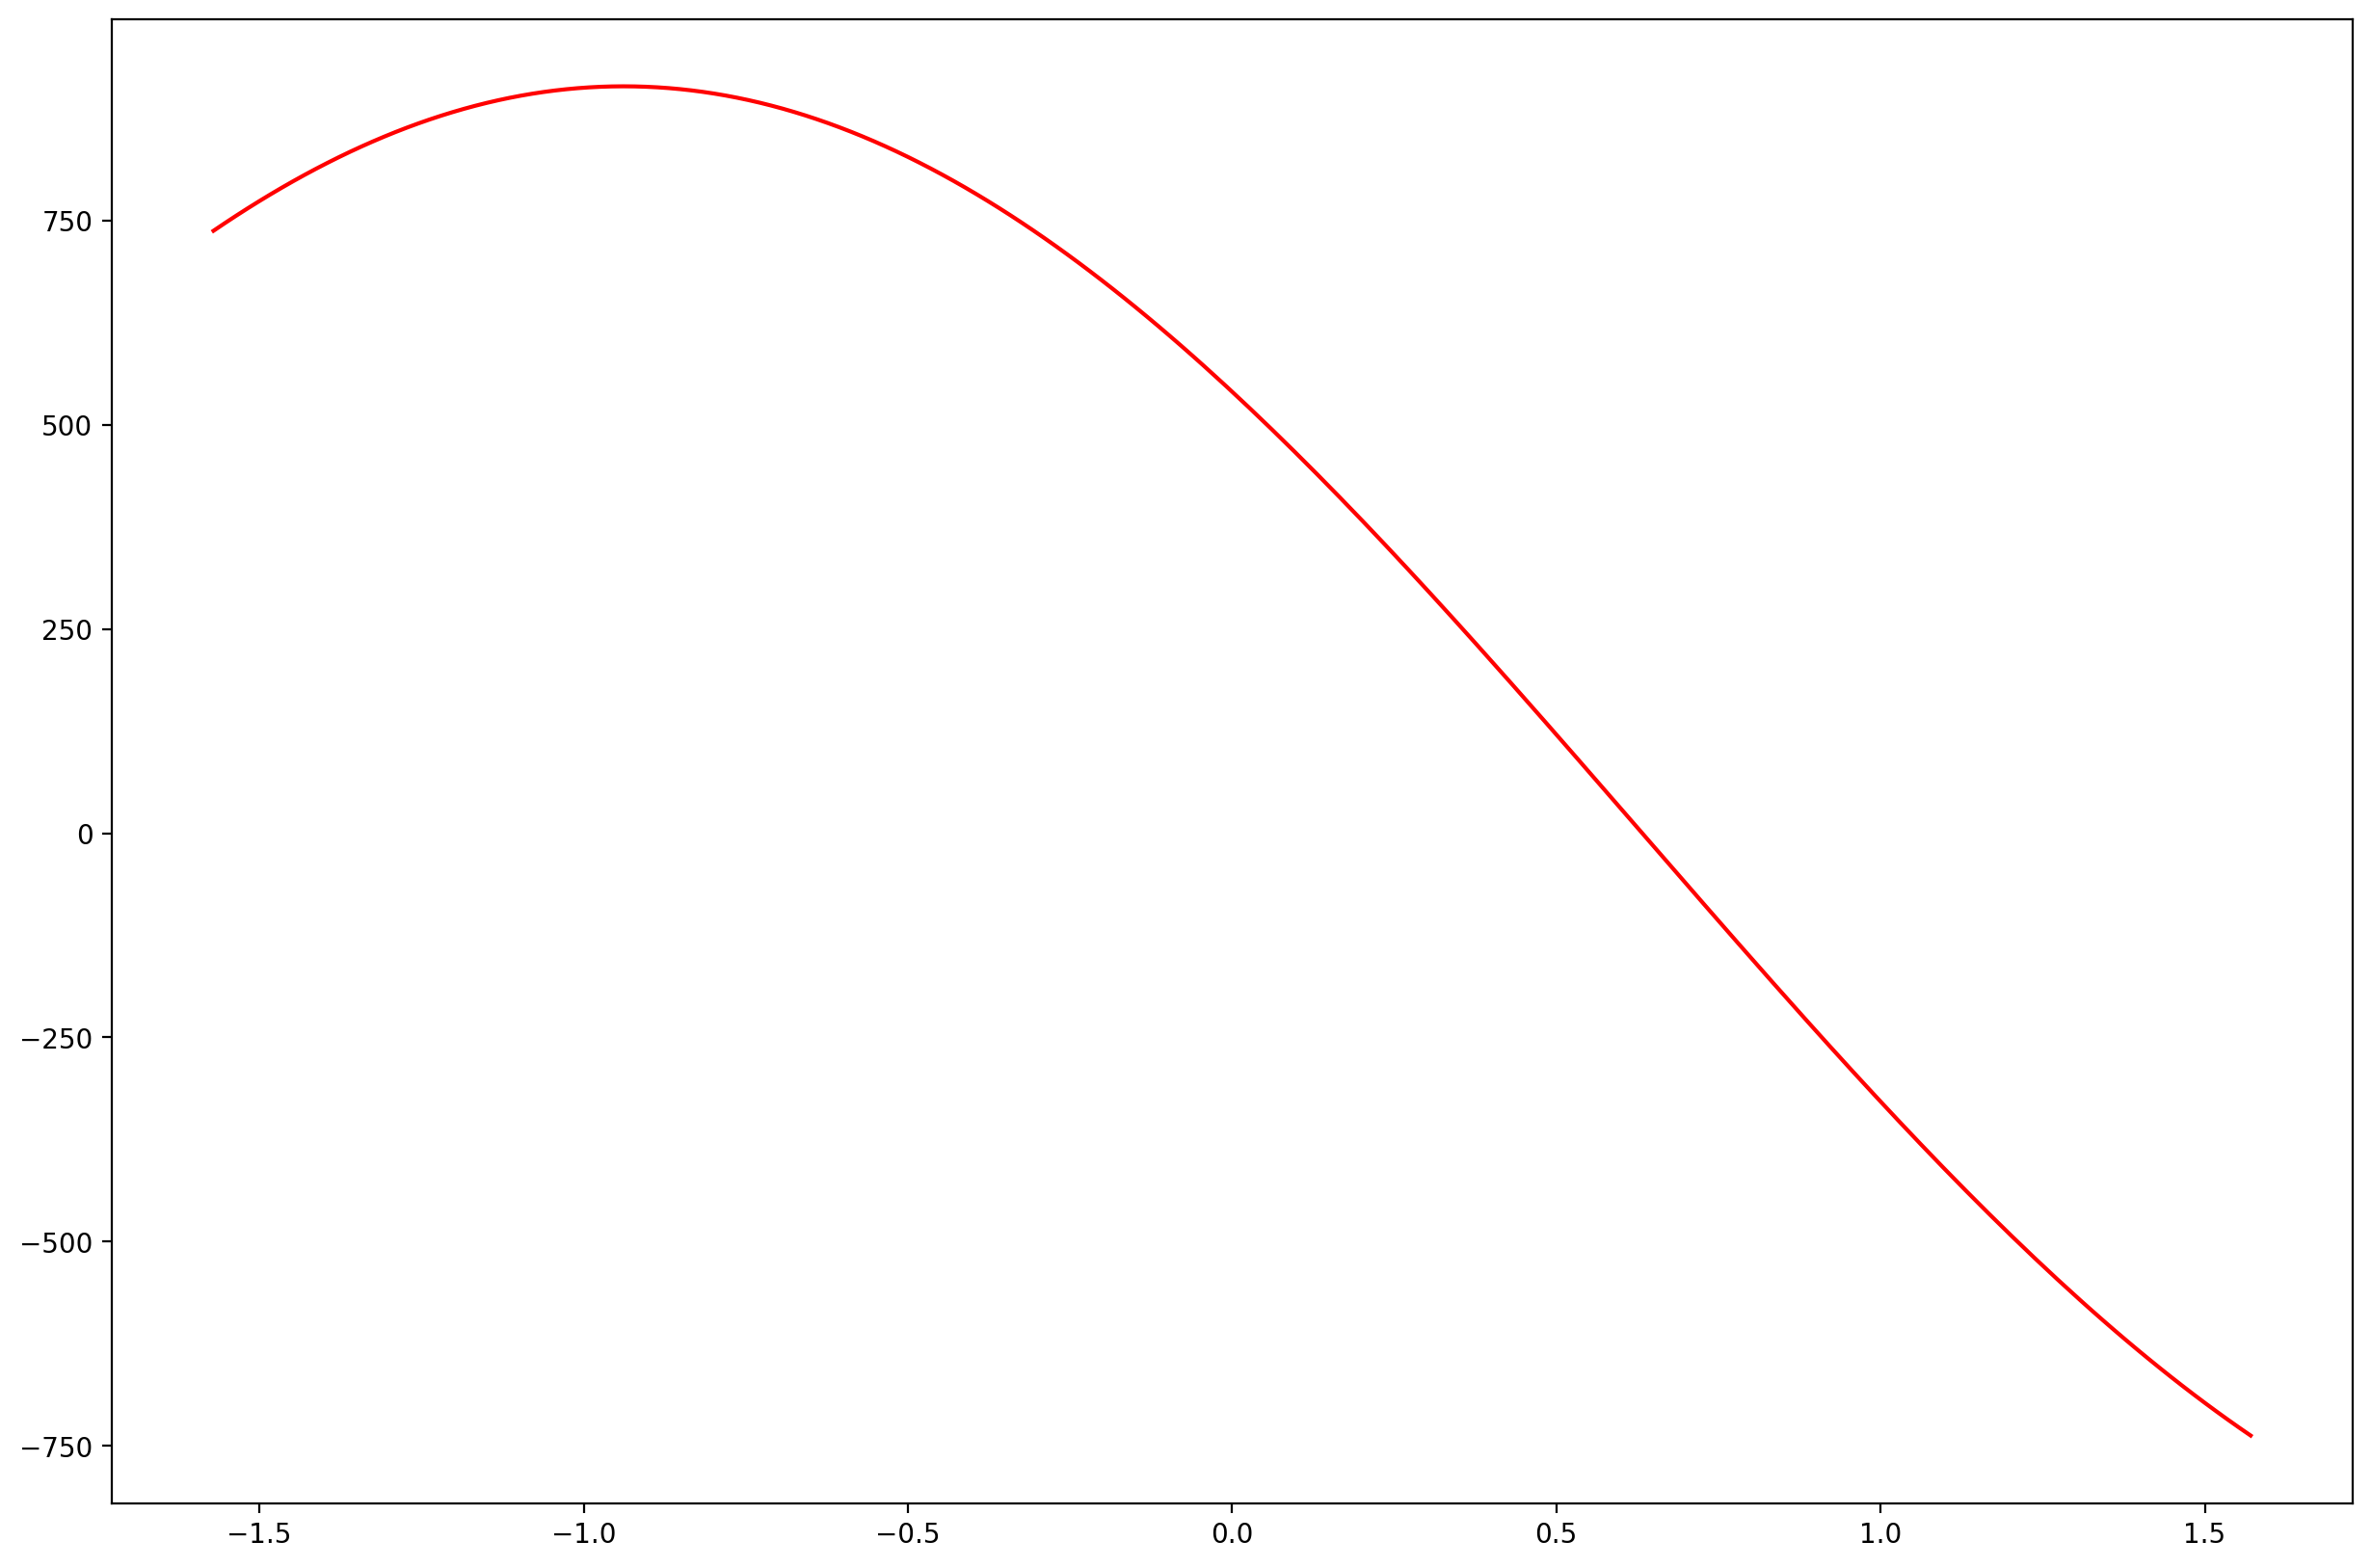

In [5]:
# get an random row from the points with seed
np.random.seed(42)
random_row = np.random.randint(0, len(points))

# get the point corresponding to the random row
random_point = points_centered[random_row]

# using the random point, plot the hough transform
theta_demo = np.linspace(-np.pi/2, np.pi/2, 180)
rho_demo = random_point[0]*np.cos(theta_demo) + random_point[1]*np.sin(theta_demo)
plt.figure(figsize=(15, 10), dpi=200)
plt.plot(theta_demo,rho_demo, 'r')

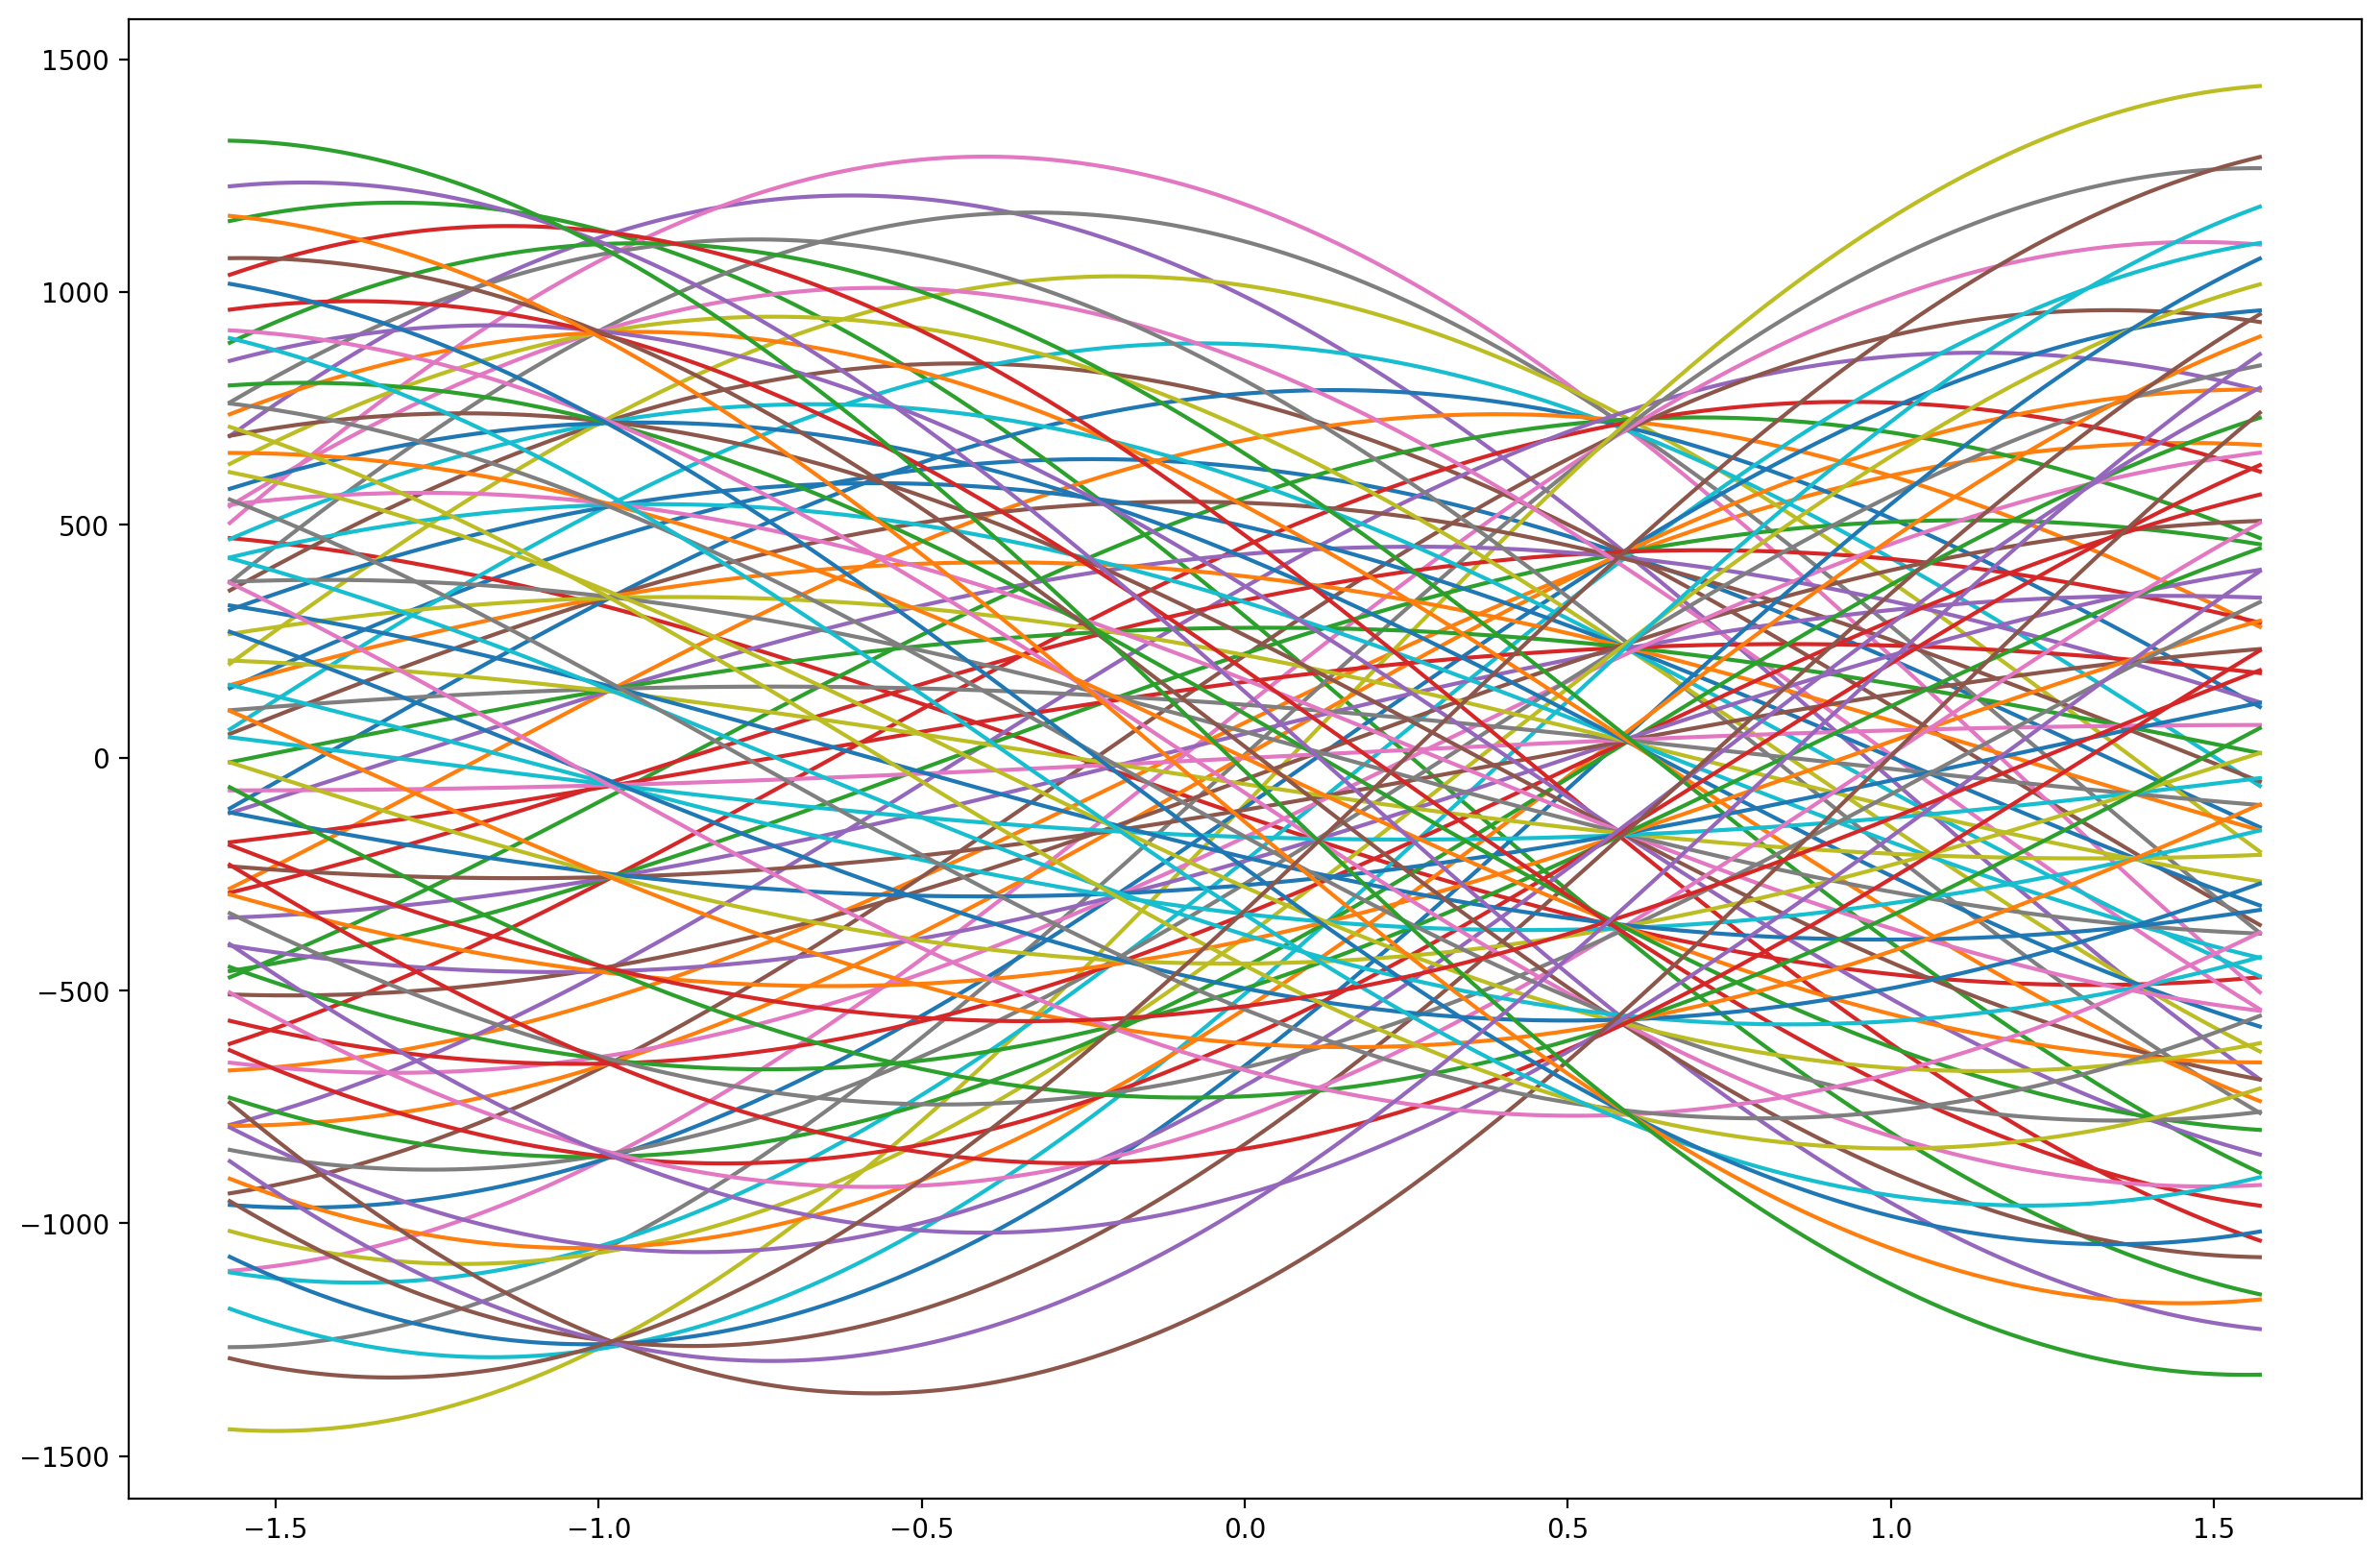

In [6]:
plt.figure(figsize=(15,10),dpi=200)

all_theta = np.linspace(-np.pi/2, np.pi/2, 180)

for pt_centered in points_centered:
    ith_rho = pt_centered[0]*np.cos(all_theta) + pt_centered[1]*np.sin(all_theta)
    plt.plot(all_theta, ith_rho)

#### 3. **提取霍夫空间中这些线的交点**
- Notes：此空间下每个交点代表实际地理平面中过两个钻孔点的线

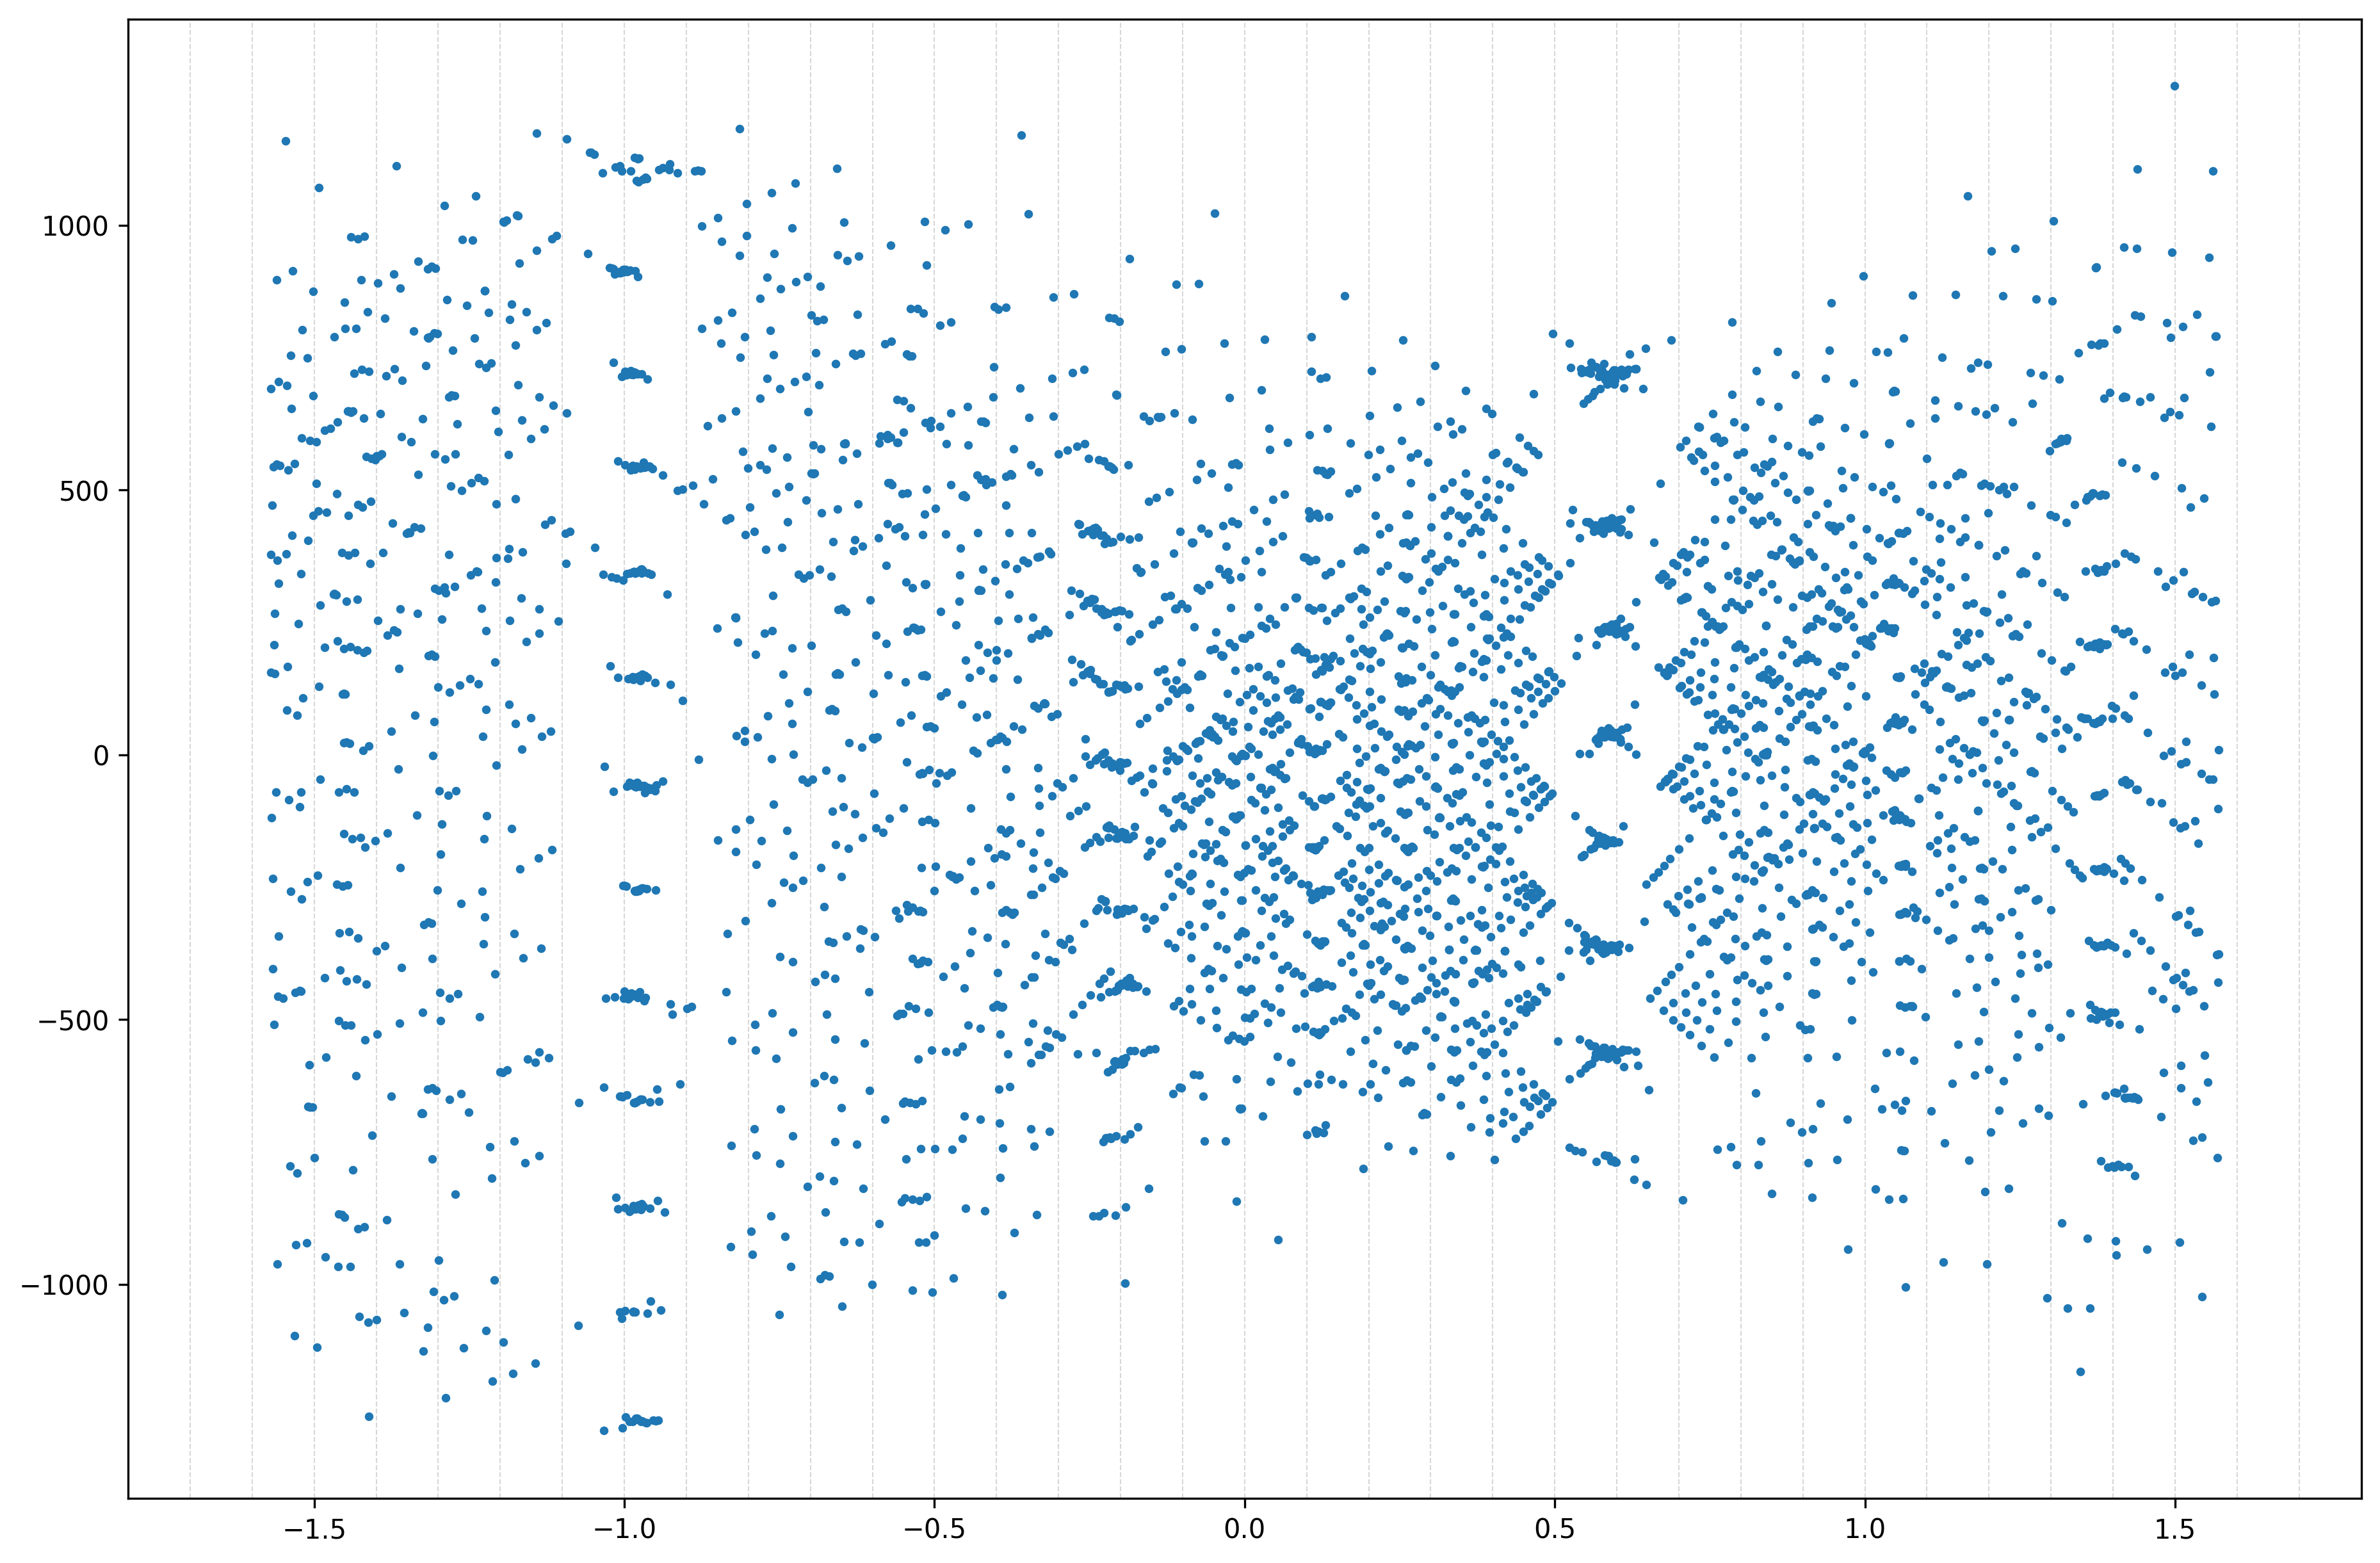

In [7]:
points_hough_space = fg.hough_transform(points)

points_hough_space_x = points_hough_space[:, 0]
points_hough_space_y = points_hough_space[:, 1]

y_min = points_hough_space_y.min() - abs(points_hough_space_y.min()) * 0.1
y_max = points_hough_space_y.max() + abs(points_hough_space_y.max()) * 0.1
x_min = -1.8
x_max = 1.8

# plt.figure(figsize=(15,10),dpi=300)
# # add vertical lines
# vlines_x = np.arange(-1.6,1.6,0.1)
# for vline_x in vlines_x:
#     vline_x = float(vline_x)
#     plt.axvline(x=vline_x, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.9)
# plt.scatter(points_hough_space_x, points_hough_space_y,s=5)


fig, ax1 = plt.subplots(figsize=(15, 10), dpi=300)
vlines_x = np.arange(x_min,x_max,0.1)
for vline_x in vlines_x:
    vline_x = float(vline_x)
    ax1.axvline(x=vline_x, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.9,zorder=0)

# plot the scatter of hough space points
ax1.set_ylim(y_min, y_max)
ax1.set_xlim(x_min, x_max)
ax1.scatter(points_hough_space_x, points_hough_space_y, s=5,zorder =5)


#### 4. 将这些交点投影至$\theta$轴，然后对$\theta$轴进行**核密度估计(kernel density estimation, KDE)**，找出核密度估计曲线中密度最大的**两个点**所对应的$\theta$值
- Notes：也可以说只对这些点的$\theta$轴分量进行核密度估计
$$\theta^*_1 = \arg\max_{\theta \in \mathcal{M}} KDE(\theta) $$
$$\theta^*_2 = \arg\max_{\theta \in \mathcal{M} \setminus {\theta^*_1}} KDE(\theta)$$
$$  \theta^*_1, \theta^*_2 = \operatorname{arg,top2}_{\theta}, KDE(\theta) $$

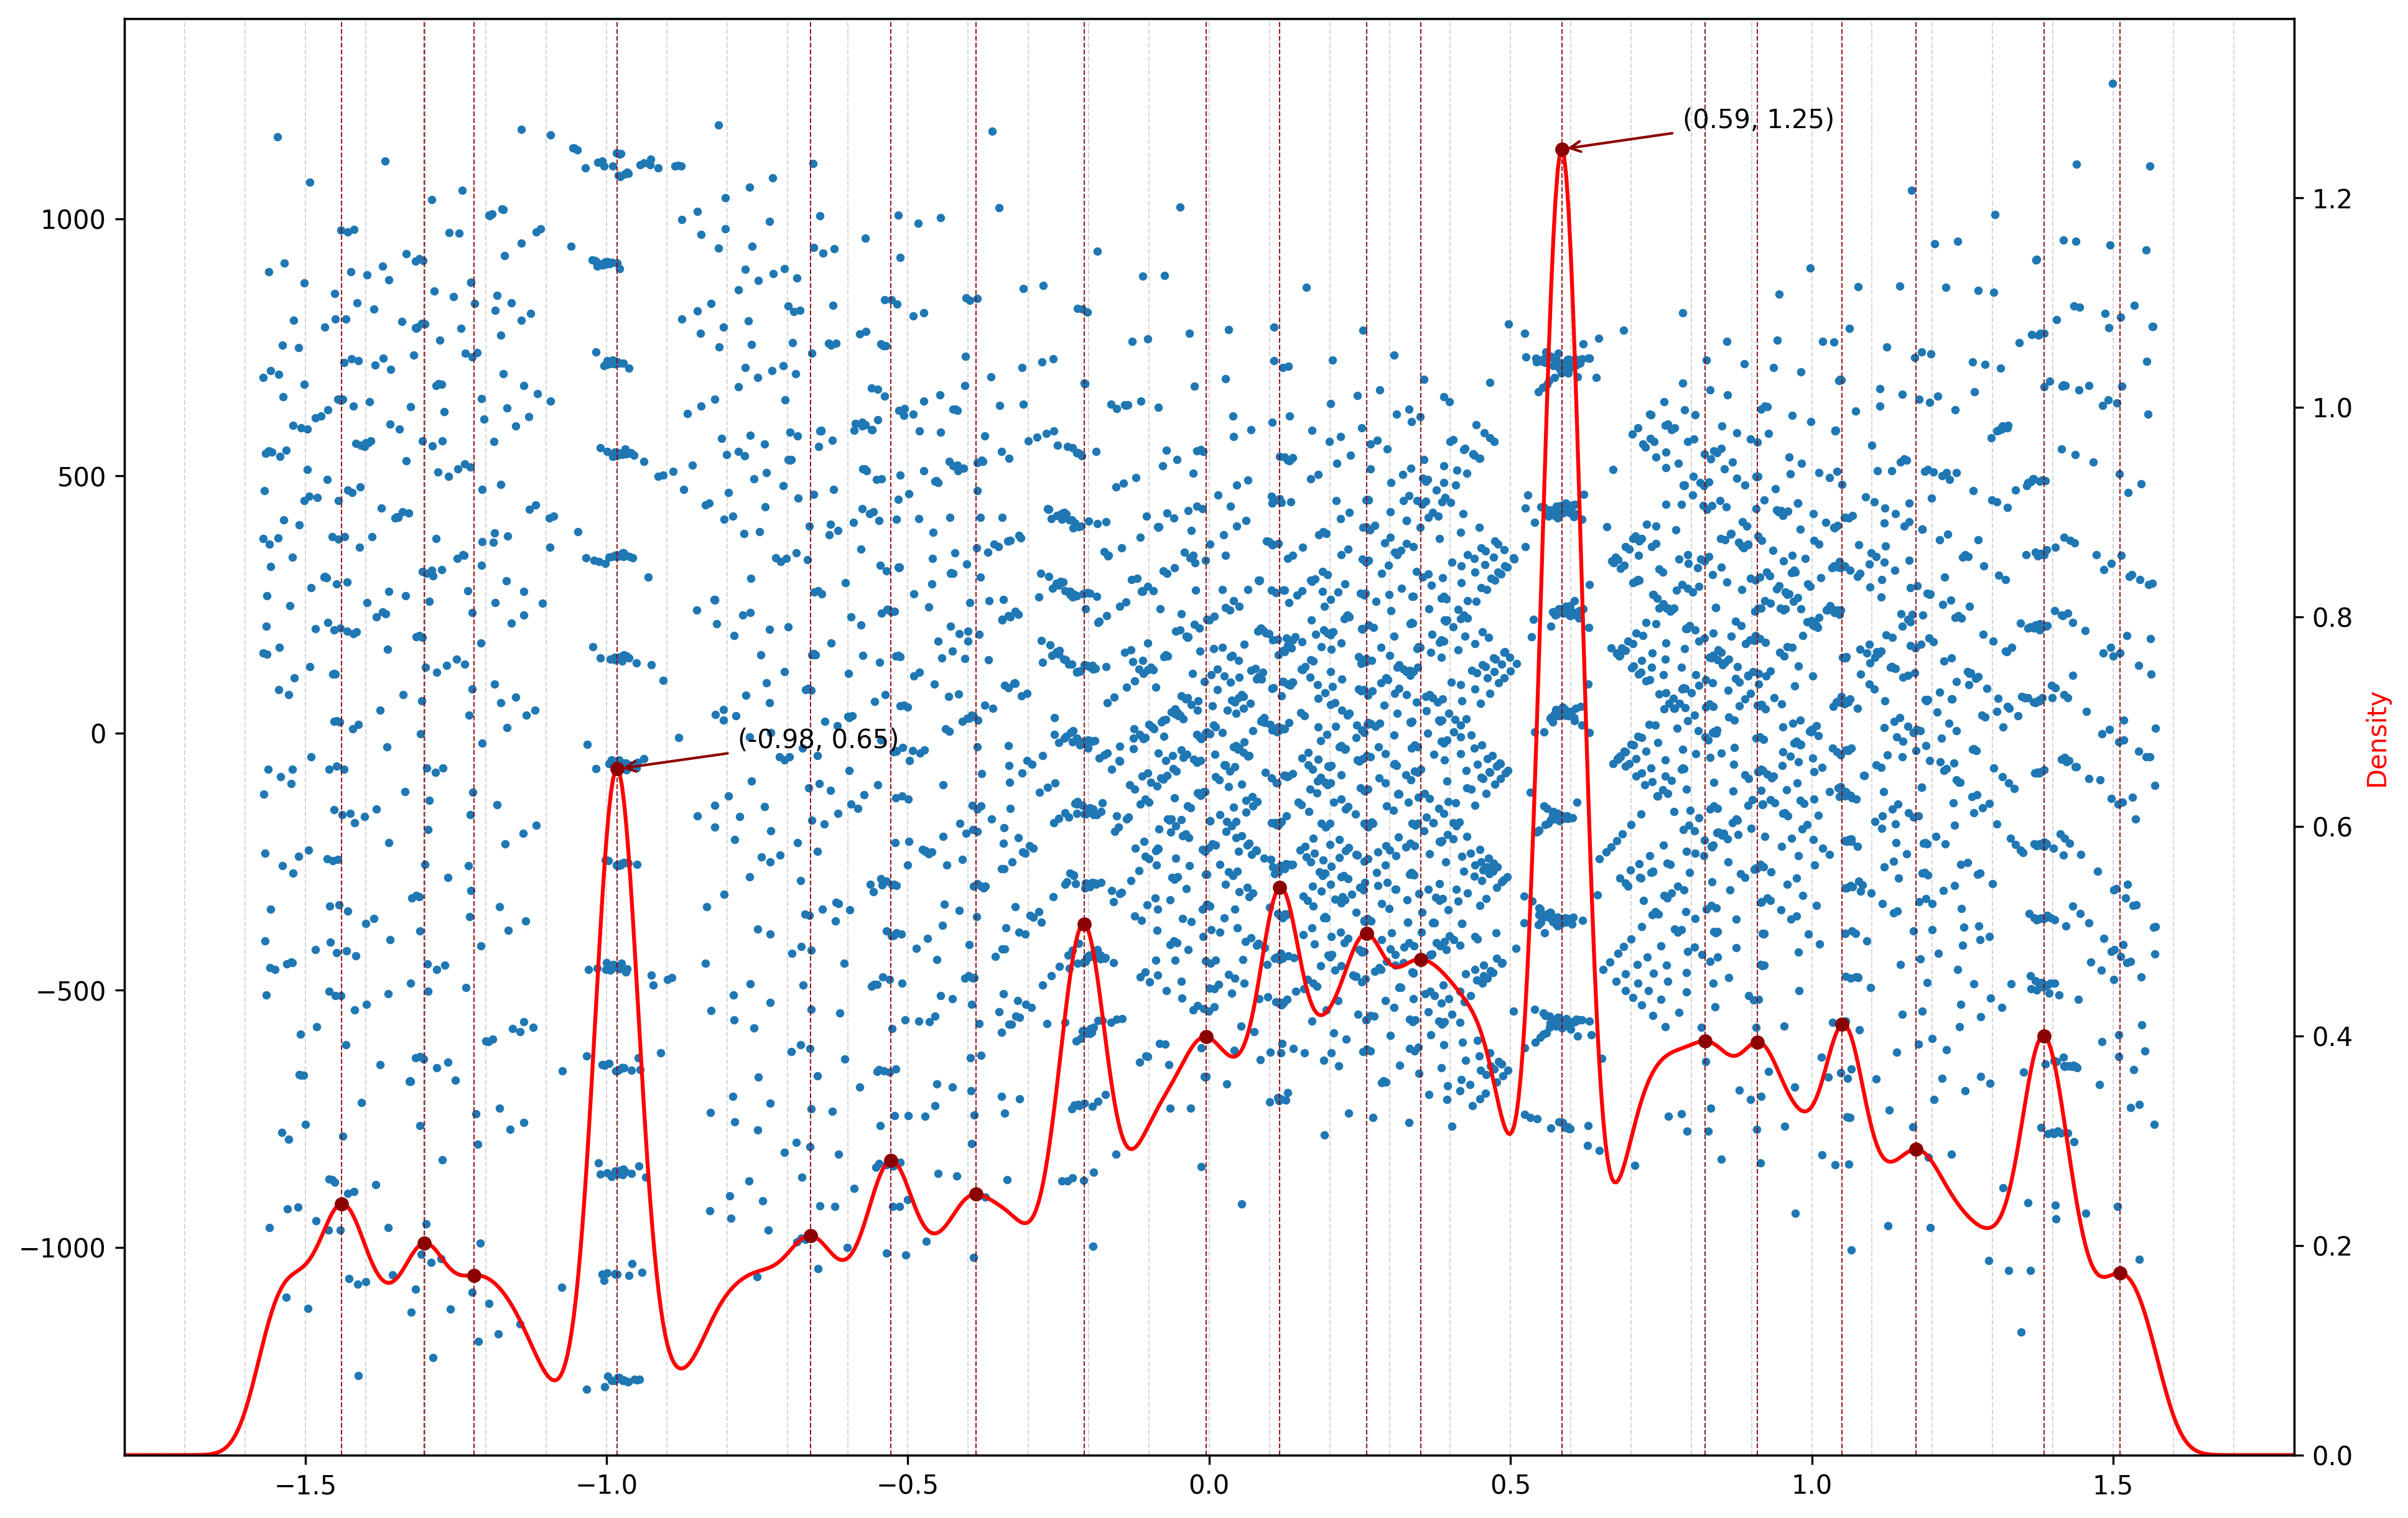

In [8]:
points_hough_space = fg.hough_transform(points)

points_hough_space_x = points_hough_space[:, 0]
points_hough_space_y = points_hough_space[:, 1]

y_min = points_hough_space_y.min() - abs(points_hough_space_y.min()) * 0.1
y_max = points_hough_space_y.max() + abs(points_hough_space_y.max()) * 0.1
x_min = -1.8
x_max = 1.8

# plt.figure(figsize=(15,10),dpi=300)
# # add vertical lines
# vlines_x = np.arange(-1.6,1.6,0.1)
# for vline_x in vlines_x:
#     vline_x = float(vline_x)
#     plt.axvline(x=vline_x, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.9)
# plt.scatter(points_hough_space_x, points_hough_space_y,s=5)


fig, ax1 = plt.subplots(figsize=(15, 10), dpi=300)
vlines_x = np.arange(x_min,x_max,0.1)
for vline_x in vlines_x:
    vline_x = float(vline_x)
    ax1.axvline(x=vline_x, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.9,zorder=0)

# plot the scatter of hough space points
ax1.set_ylim(y_min, y_max)
ax1.set_xlim(x_min, x_max)
ax1.scatter(points_hough_space_x, points_hough_space_y, s=5,zorder =5)
# plot the KDE of hough space points
ax2 = ax1.twinx()

kde = stats.gaussian_kde(points_hough_space_x,bw_method=0.04)
kde_x = np.linspace(x_min, x_max, 1000)
kde_y = kde(kde_x)


# the kde curve
ax2.plot(kde_x, kde_y, color='red', label='KDE',zorder = 2)
ax2.set_ylim(0, kde_y.max()*1.1)
ax2.set_ylabel('Density', color='red')

# the kde peaks
peaks, _ = find_peaks(kde_y)
peak_x = kde_x[peaks]
peak_y = kde_y[peaks]


ax2.scatter(peak_x, peak_y, color='darkred',s=20, label='KDE peaks',zorder =3)
for pk_x in peak_x:
    ax2.axvline(x=pk_x, color='darkred', linestyle='--', linewidth=0.5, alpha=0.9,zorder=1)

peak_x = peak_x.reshape(-1,1)
peak_y = peak_y.reshape(-1,1)
peak_xy = np.hstack((peak_x,peak_y))
top_two_peaks = fg.find_top_two_kde_peaks(peak_xy)

for i,(px,py) in enumerate(top_two_peaks):
    ax2.annotate(f'({px:.2f}, {py:.2f})', 
                 xy=(px, py), 
                 xytext=(px+0.2, py+0.02),
                 arrowprops=dict(arrowstyle='->', color='darkred'),
                 fontsize=10,
                 zorder =3)



#### 5. 以$(\mathbf{i}', \mathbf{j}')$为**基（basis）** 表示原本地理空间中的点，即线性坐标变换
- Notes：原本的地理空间坐标系的基为：$\mathbf{i} = (1, 0), \quad \mathbf{j} = (0, 1)$


- 而现在的基为：$\mathbf{i}' = (\cos\theta^*_1, \sin\theta^*_1), \quad \mathbf{j}'= (\cos\theta^*_2, \sin\theta^*_2) $
- 任何二维向量 $v$ 都可以在这两个基下表示为：$v = x\cdot\mathbf{i} + y\cdot\mathbf{j} = x'\cdot\mathbf{i}' + y'\cdot\mathbf{j}' $
- 写成矩阵表达为
$$
\begin{bmatrix} x \quad y \end{bmatrix}
\underbrace{\begin{bmatrix}  
1 & 0 \\  
0 & 1  
\end{bmatrix}}_{I}=
\begin{bmatrix} x' \quad y' \end{bmatrix}
\underbrace{\begin{bmatrix}  
\cos\theta_1 & \sin\theta_1 \\  
\cos\theta_2 & \sin\theta_2  
\end{bmatrix}}_{A}  
  
$$

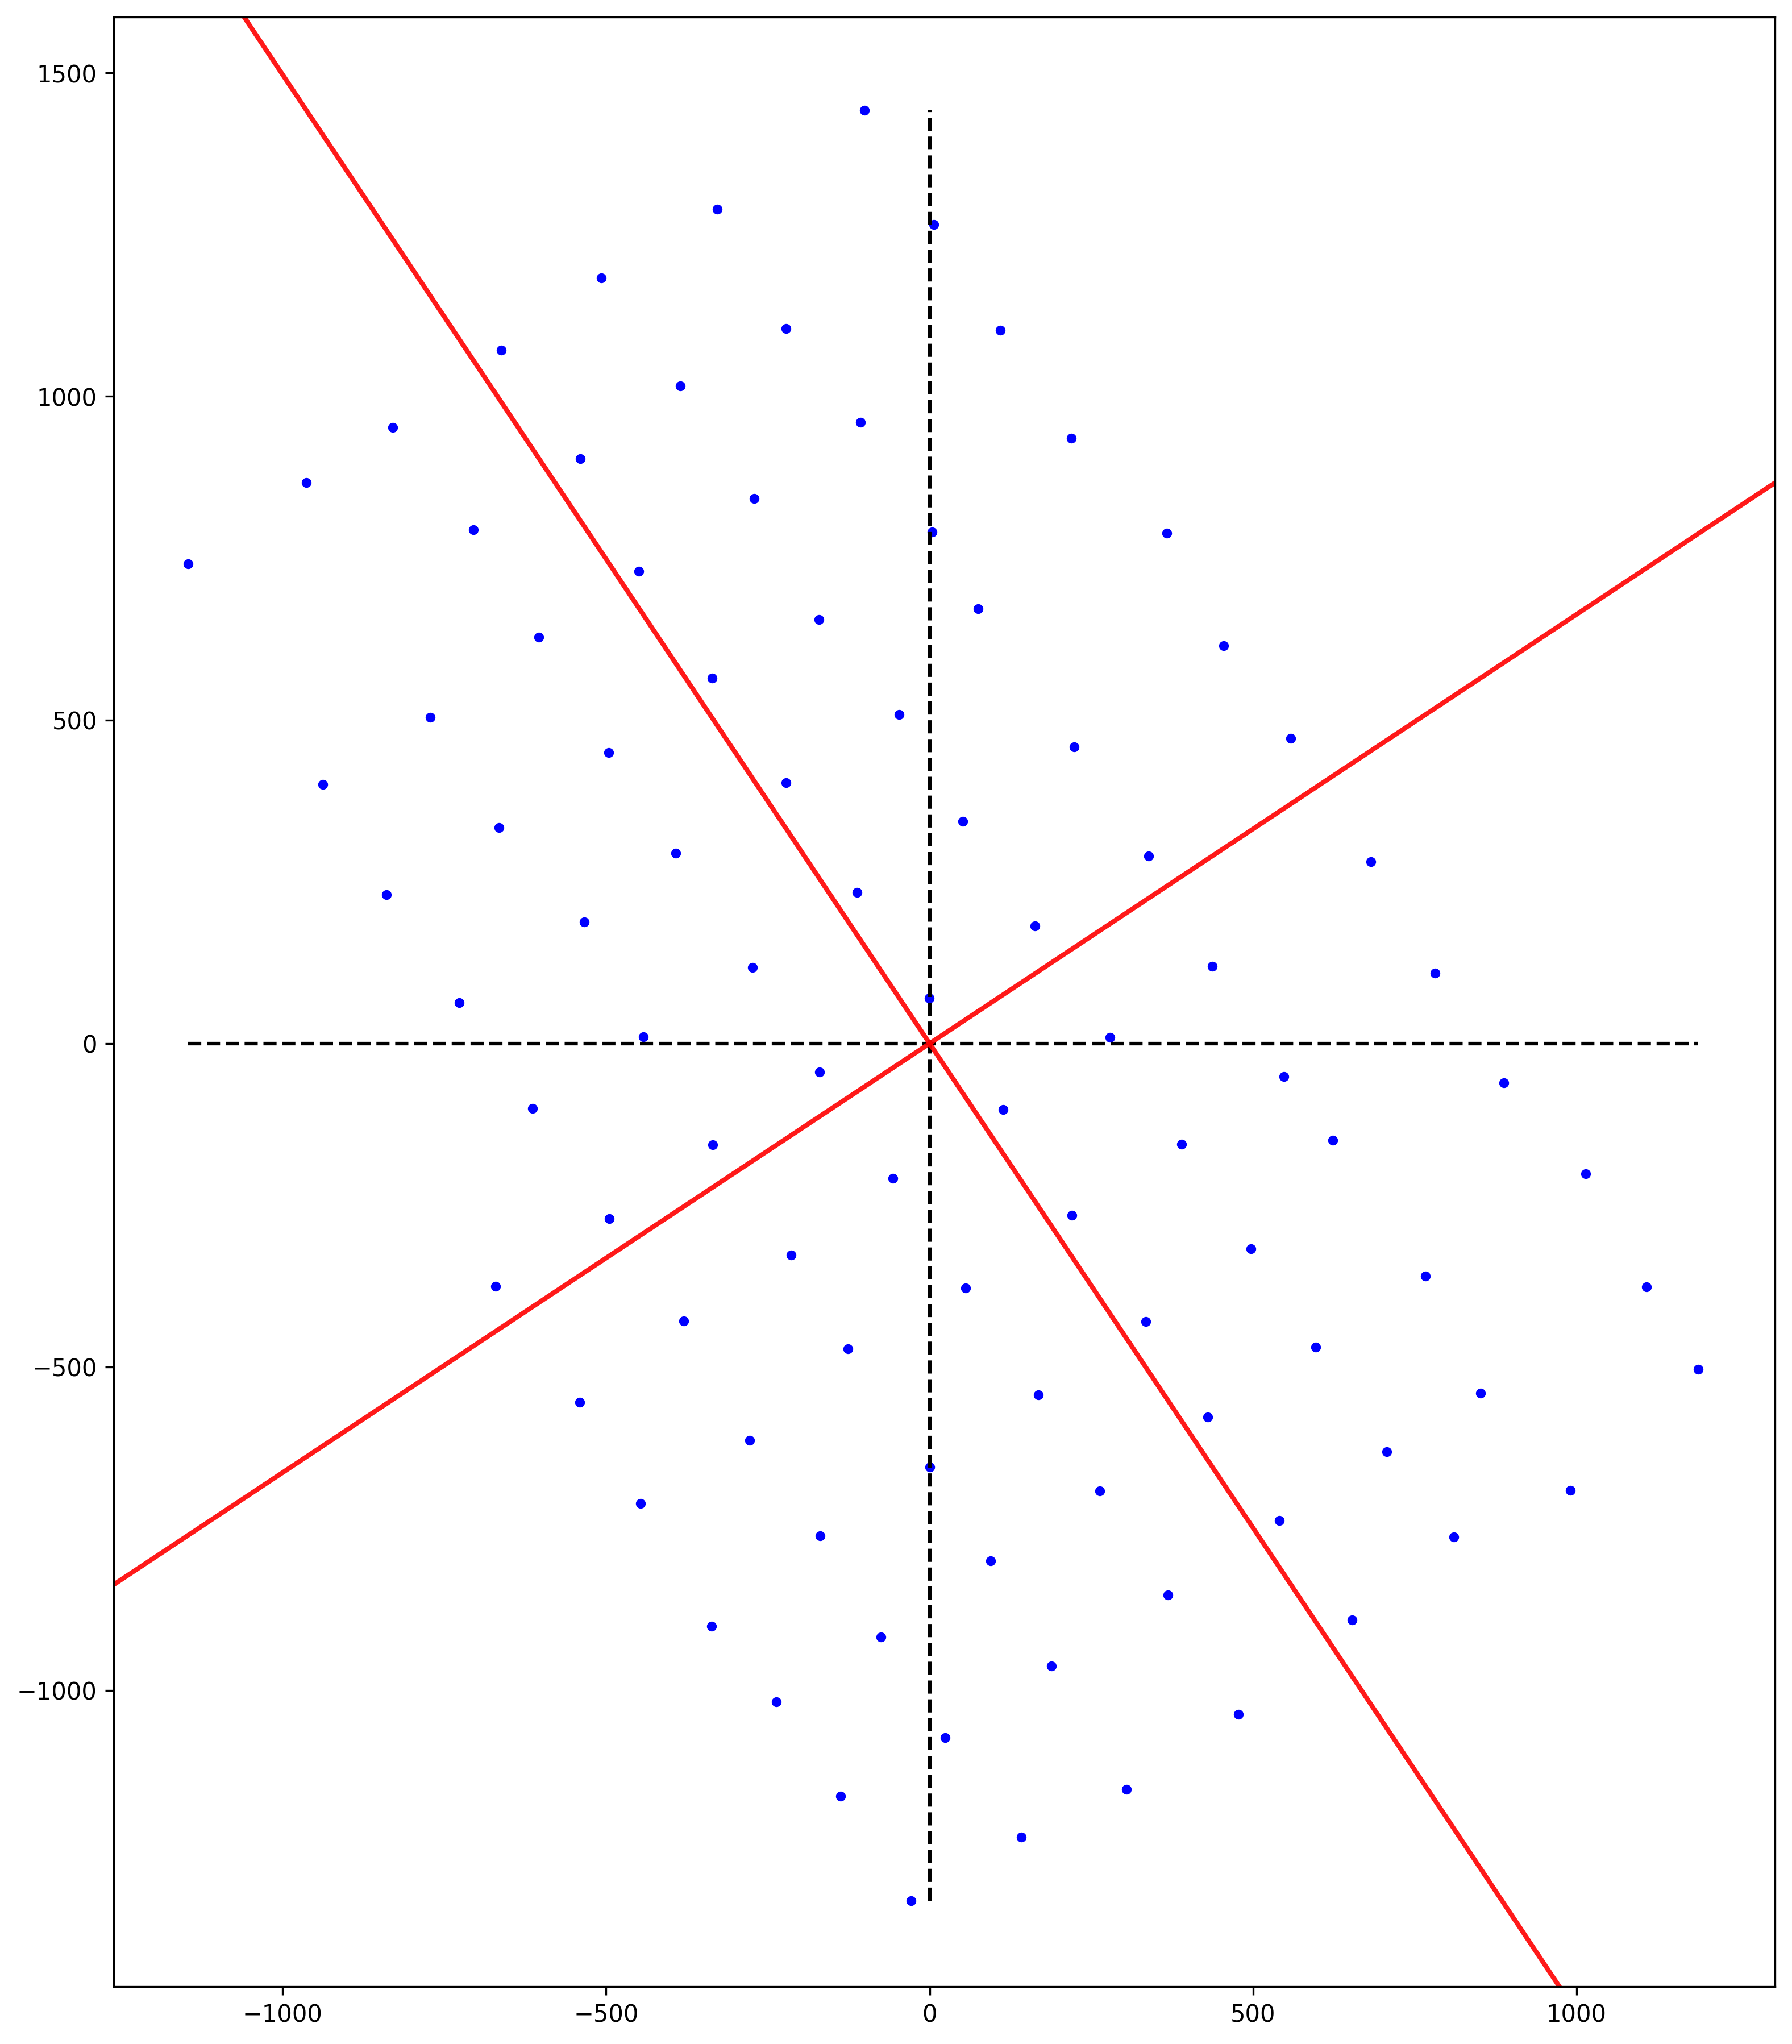

In [9]:
centre = np.mean(points, axis=0)
points_centered = points - centre

points_centered_x_min = points_centered[:,0].min()-abs(points_centered[:,0].min())*0.1
points_centered_x_max = points_centered[:,0].max()+abs(points_centered[:,0].max())*0.1
points_centered_y_min = points_centered[:,1].min()-abs(points_centered[:,1].min())*0.1
points_centered_y_max = points_centered[:,1].max()+abs(points_centered[:,1].max())*0.1

plt.figure(figsize=(15, 15),dpi=300)
# plot lines that x=0 and y=0 as the grey solid lines
plt.plot([points_centered[:,0].min(), points_centered[:,0].max()], [0, 0], 'k--')
plt.plot([0, 0], [points_centered[:,1].min(), points_centered[:,1].max()], 'k--')
plt.xlim(points_centered_x_min, points_centered_x_max)
plt.ylim(points_centered_y_min, points_centered_y_max)
plt.gca().set_aspect('equal')
plt.scatter(points_centered[:,0], points_centered[:,1], s=10, c='b')

theta_i = top_two_peaks[0,0]
theta_j = top_two_peaks[1,0]



def get_line_by_angle(angle_radians, x_min, x_max, **kwargs):
    """
    绘制指定角度的直线
    
    参数:
    angle_radians: 弧度
    x_range: x轴范围
    **kwargs: 传递给plot的参数
    """

    
    # 计算斜率
    slope = np.tan(angle_radians)
    
    # 生成x值
    x = np.linspace(x_min, x_max, 100)
    
    # 计算对应的y值（通过原点）
    y = slope * x
    
    # 绘制直线
    
    return x,y

theta_i_x,theta_i_y = get_line_by_angle(theta_i, points_centered_x_min, points_centered_x_max)
theta_j_x,theta_j_y = get_line_by_angle(theta_j, points_centered_x_min, points_centered_x_max)

plt.plot(theta_i_x, theta_i_y, c='red',alpha=0.9,linewidth=2)
plt.plot(theta_j_x, theta_j_y, c='red',alpha=0.9,linewidth=2)


#### 6. 在以$(\mathbf{i}',\mathbf{j}')$为基的线性空间下，分别对$\mathbf{i}'$轴和$\mathbf{j}'$轴进行核密度估计。

C:\Users\wukon\AppData\Local\Temp\ipykernel_28480\643587092.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


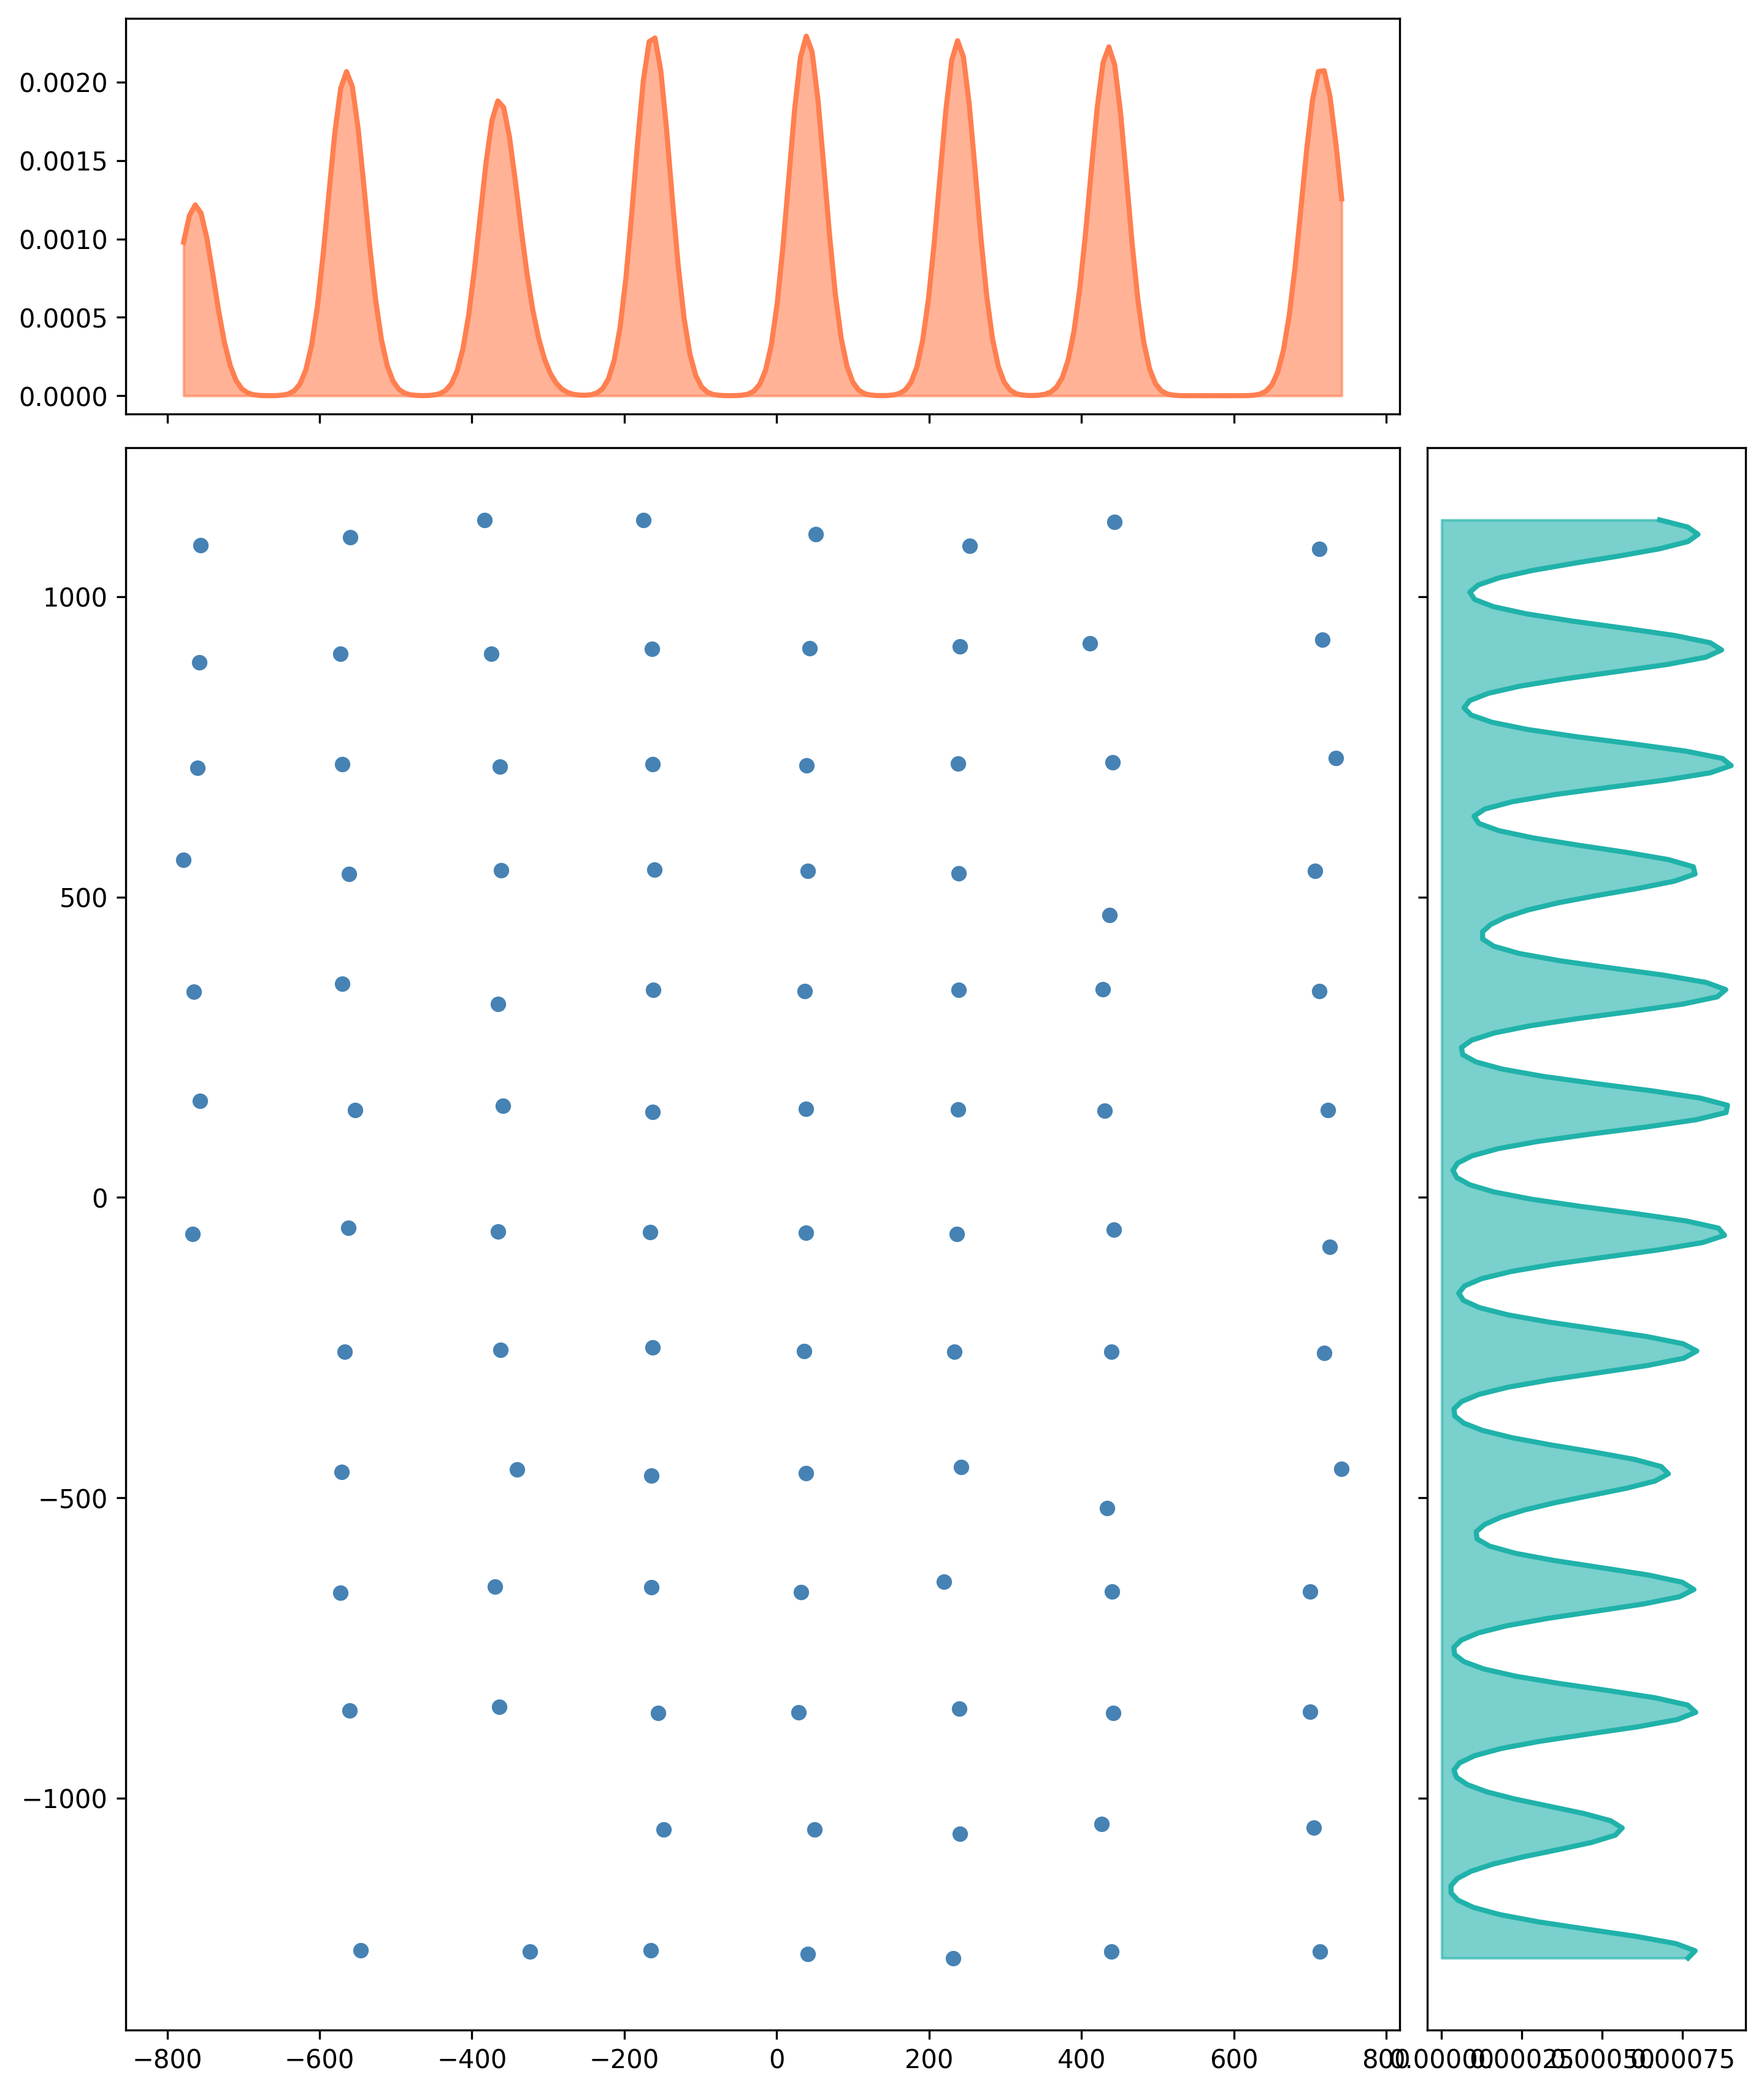

In [10]:
basis_i = np.array([cos(theta_i), sin(theta_i)])
basis_j = np.array([cos(theta_j), sin(theta_j)])

transformed_points = fg.transform_along_basis(points_centered, basis_i, basis_j)
grids_i_axes = fg.find_kde_peaks(transformed_points[:, 0], bw=0.05)[:, 0]
grids_j_axes = fg.find_kde_peaks(transformed_points[:, 1], bw=0.05)[:, 0]

# 创建图形布局
fig = plt.figure(figsize=(12, 15),dpi=300)
gs = fig.add_gridspec(3, 3, width_ratios=[4, 1, 0.2], height_ratios=[1, 4, 0.2],hspace=0.05, wspace=0.05)

# 主散点图
ax_scatter = fig.add_subplot(gs[1, 0])
# x轴KDE
ax_kde_x = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
# y轴KDE
ax_kde_y = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

# 手动计算KDE
def plot_custom_kde(data, ax, orientation='horizontal', color='steelblue'):
    """手动绘制KDE图"""
    kde = stats.gaussian_kde(data,bw_method=0.05)
    x_range = np.linspace(min(data), max(data), 200)
    y_kde = kde(x_range)

    if orientation == 'horizontal':
        ax.fill_between(x_range, y_kde, alpha=0.6, color=color)
        ax.plot(x_range, y_kde, color=color, linewidth=2)
        # ax.set_ylabel('密度')
    else:
        ax.fill_betweenx(x_range, y_kde, alpha=0.6, color=color)
        ax.plot(y_kde, x_range, color=color, linewidth=2)
        # ax.set_xlabel('密度')

# 绘制散点图
ax_scatter.scatter(x=transformed_points[:,0], y=transformed_points[:,1], s=50, alpha=1, color='steelblue', edgecolor='white')
# ax_scatter.set_xlabel('X轴')
# ax_scatter.set_ylabel('Y轴')
# ax_scatter.grid(True, alpha=0.3)

# 绘制x轴KDE
plot_custom_kde(transformed_points[:,0], ax_kde_x, 'horizontal', 'coral')
ax_kde_x.tick_params(axis='x', labelbottom=False)
# ax_kde_x.set_title('X轴KDE分布', fontsize=10)

# 绘制y轴KDE
plot_custom_kde(transformed_points[:,1], ax_kde_y, 'vertical', 'lightseagreen')
ax_kde_y.tick_params(axis='y', labelleft=False)
# ax_kde_y.set_title('Y轴KDE分布', fontsize=10)


# plt.suptitle('自定义散点图与KDE分布', fontsize=14, fontweight='bold')
plt.tight_layout()




#### 7. 取核密度估计函数的峰值点所对应的值作为节点，按照从小到大的顺序排序，构建**峰值矩阵$K=[k_{rs}]$**。


$$
K=\underbrace{
\left[
\begin{array}{cccc}
(p^*_{i,1},p^*_{j,1}) & (p^*_{i,2},p^*_{j,1}) & \cdots & (p^*_{i,n},p^*_{j,1})\\
(p^*_{i,1},p^*_{j,2}) & (p^*_{i,2},p^*_{j,2}) & \cdots & (p^*_{i,n},p^*_{j,2})\\
\vdots & \vdots & \ddots & \vdots\\
(p^*_{i,1},p^*_{j,m}) & (p^*_{i,m},p^*_{j,m}) & \cdots & (p^*_{i,n},p^*_{j,m})
\end{array}
\right]
}_{n~\text{列}}

\left.\vphantom{
\begin{array}{c}
a_{11}\\
a_{21}\\
\cdots\\
a_{11}
\end{array}}\right\} 
{^{m~\text{行}}}
$$


- 相应于峰值矩阵的**自适应网格矩阵**为


$$
\underbrace{
\left[
\begin{array}{cccc}
(1,1) & (2,1) & \cdots & (n,1)\\
(1,2) & (2,2) & \cdots & (n,2)\\
\vdots & \vdots & \ddots & \vdots\\
(1,m) & (2,m) & \cdots & (n,m)
\end{array}
\right]
}_{n}

\left.\vphantom{
\begin{array}{c}
a_{11}\\
a_{21}\\
\cdots\\
a_{11}
\end{array}}\right\} 
{m}
$$


- 将峰值矩阵与新的线性变换空间中的点$[X',Y']$相减，生成距离矩阵$D=[d_{rs}]$。


$$
\left[
\begin{array}{cccc}
(p^*_{i,1},p^*_{j,1}) & (p^*_{i,2},p^*_{j,1}) & \cdots & (p^*_{i,n},p^*_{j,1})\\
(p^*_{i,1},p^*_{j,2}) & (p^*_{i,2},p^*_{j,2}) & \cdots & (p^*_{i,n},p^*_{j,2})\\
\vdots & \vdots & \ddots & \vdots\\
(p^*_{i,1},p^*_{j,m}) & (p^*_{i,m},p^*_{j,m}) & \cdots & (p^*_{i,n},p^*_{j,m})
\end{array}
\right]
-
\begin{bmatrix}X'\\Y'\end{bmatrix}^T
=
\underbrace{
\left[
\begin{array}{cccc}
(p^*_{i,1}-X',p^*_{j,1}-Y') & (p^*_{i,2}-X',p^*_{j,1}-Y') & \cdots & (p^*_{i,n}-X',p^*_{j,1}-Y')\\
(p^*_{i,1}-X',p^*_{j,2}-Y') & (p^*_{i,2}-X',p^*_{j,2}-Y') & \cdots & (p^*_{i,n}-X',p^*_{j,2}-Y')\\
\vdots & \vdots & \ddots & \vdots\\
(p^*_{i,1}-X',p^*_{j,m}-Y') & (p^*_{i,m}-X',p^*_{j,m}-Y') & \cdots & (p^*_{i,n}-X',p^*_{j,m}-Y')
\end{array}
\right]
}_{\text{距离矩阵}}
$$


- 找出距离矩阵中的最小值，获得该值在距离矩阵中的位置，以这个位置作为点$[X',Y']$对应的钻孔在适应性网格的位置。$$(r^*,s^*) = \arg\max_{r,s} |d_{rs}|$$


- 逐个点重复第7步，即可获得钻孔自适应性网格。

C:\Users\wukon\AppData\Local\Temp\ipykernel_28480\1254110665.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


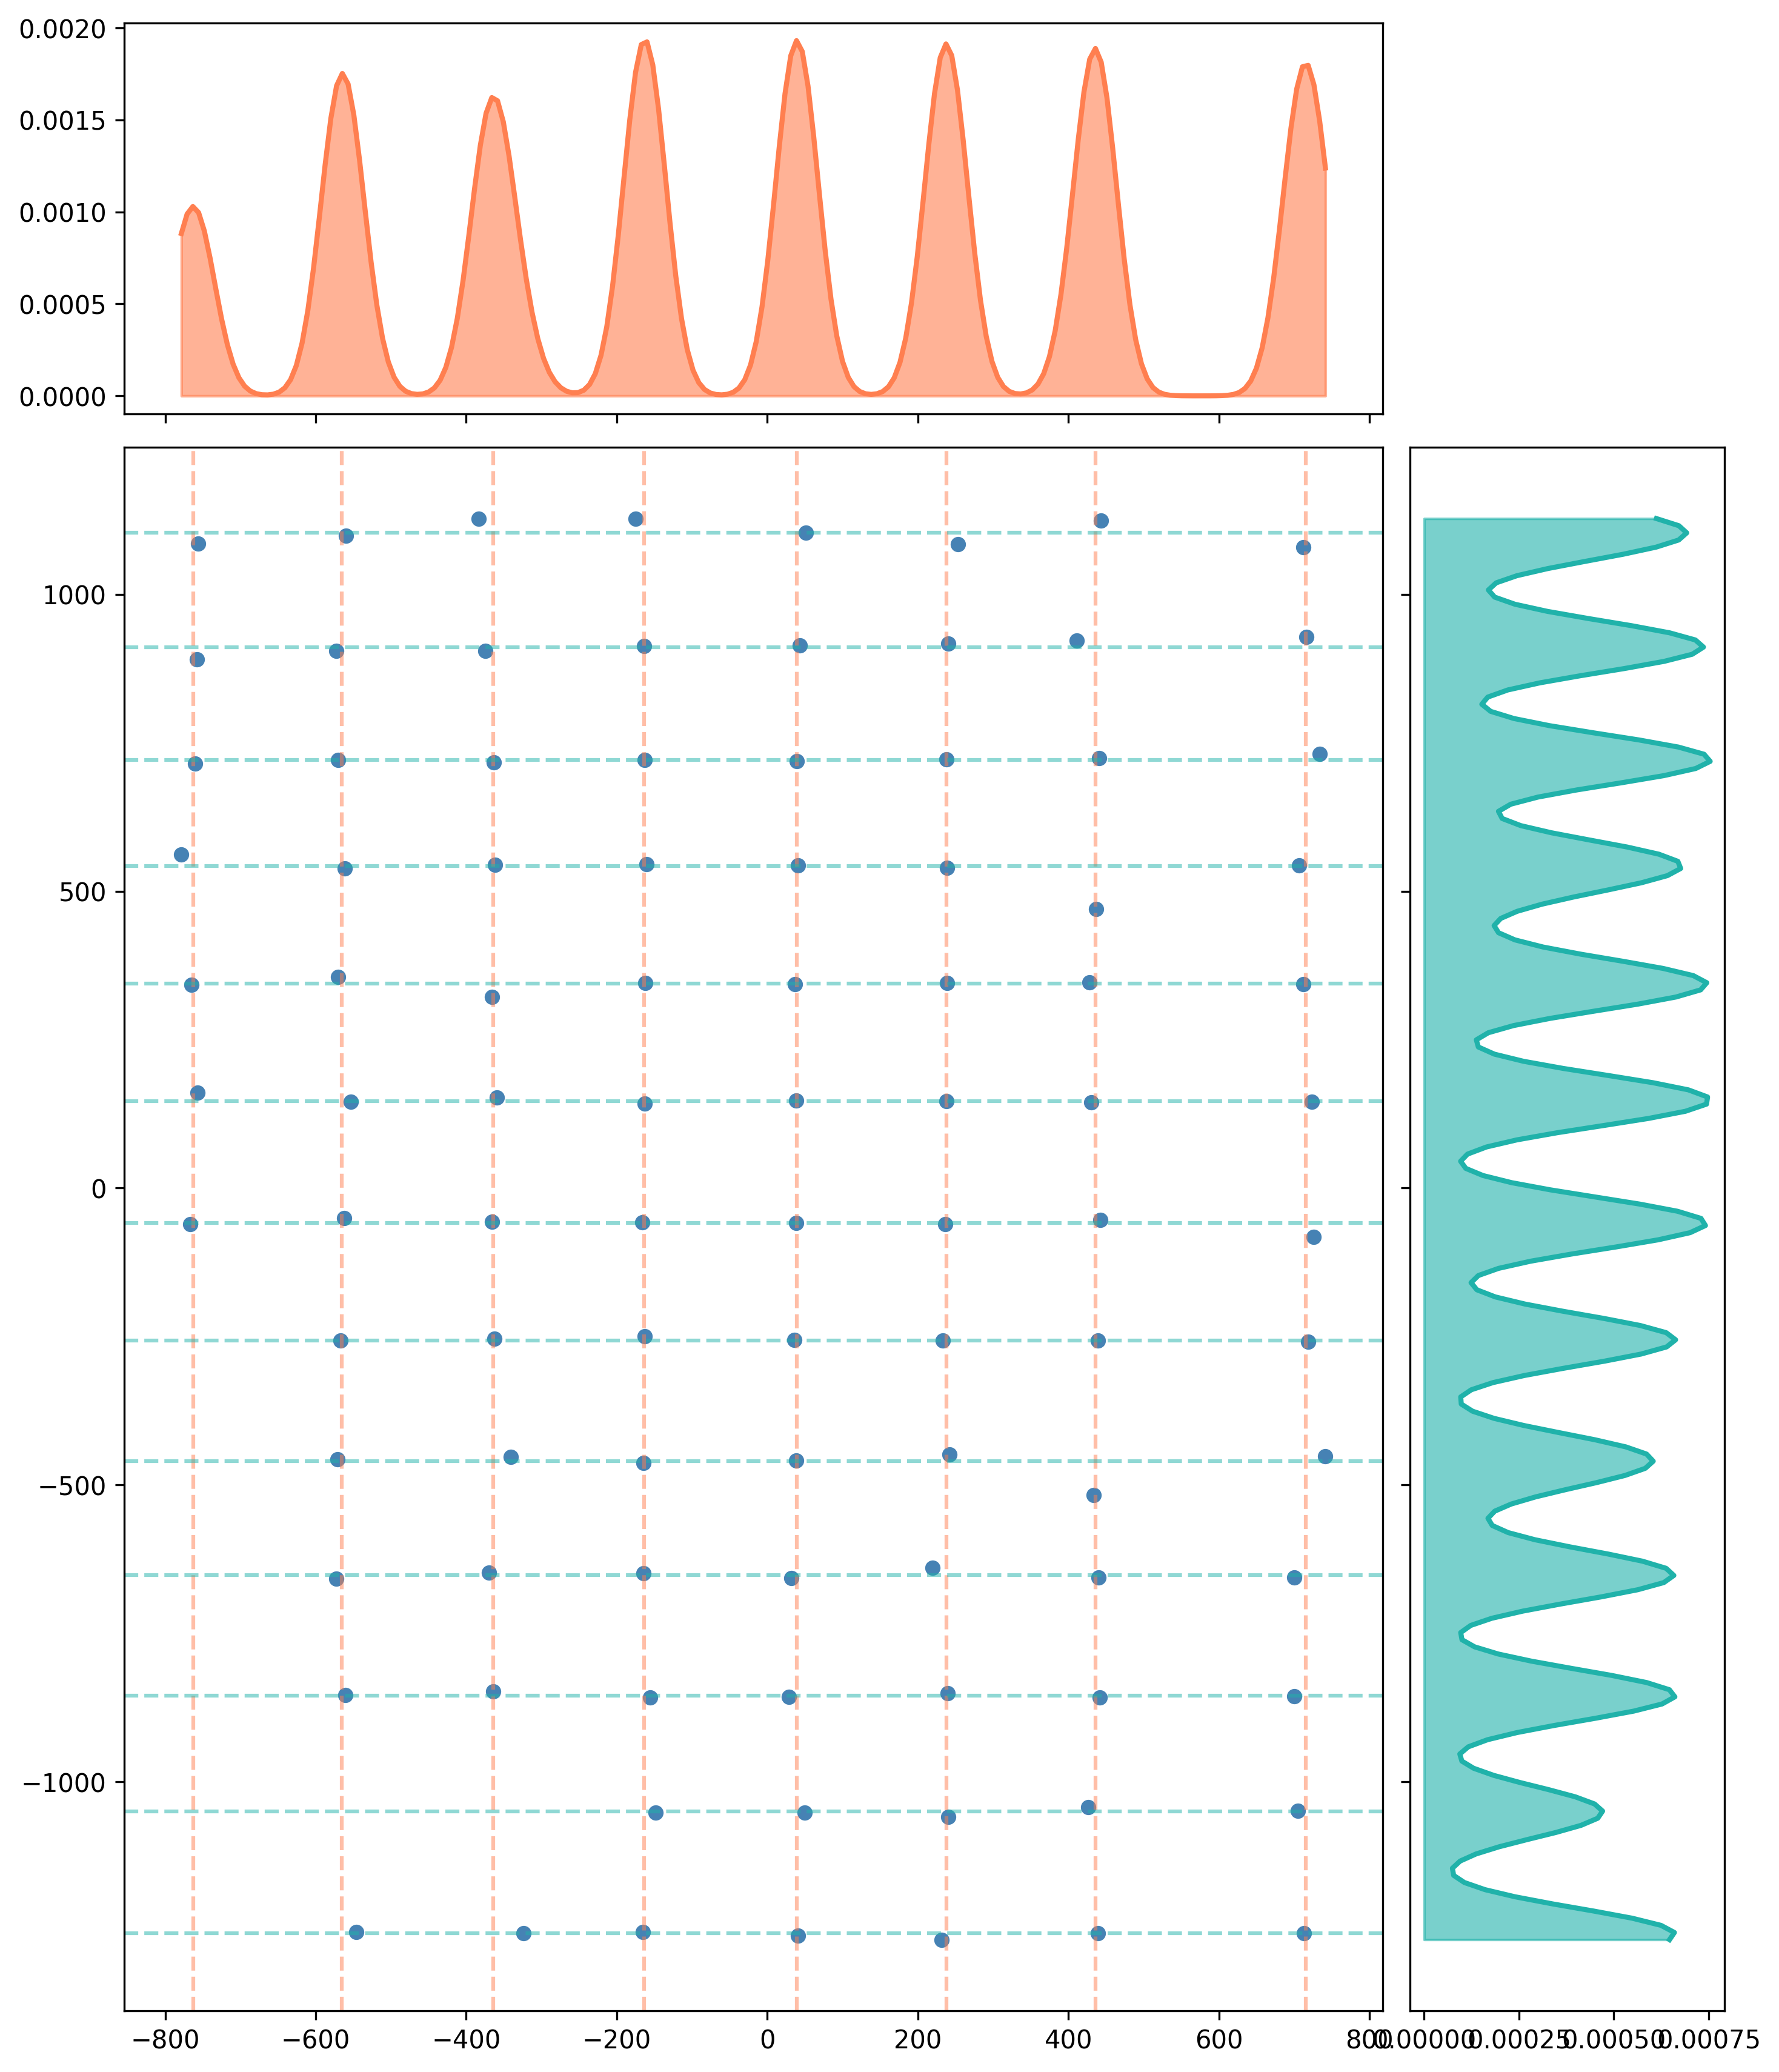

In [11]:
basis_i = np.array([cos(theta_i), sin(theta_i)])
basis_j = np.array([cos(theta_j), sin(theta_j)])

transformed_points = fg.transform_along_basis(points_centered, basis_i, basis_j)
grids_i_axes = fg.find_kde_peaks(transformed_points[:, 0], bw=0.06)[:, 0]
grids_j_axes = fg.find_kde_peaks(transformed_points[:, 1], bw=0.06)[:, 0]

# 创建图形布局
fig = plt.figure(figsize=(12, 15),dpi=300)
gs = fig.add_gridspec(3, 3, width_ratios=[4, 1, 0.2], height_ratios=[1, 4, 0.2],hspace=0.05, wspace=0.05)

# 主散点图
ax_scatter = fig.add_subplot(gs[1, 0])
# x轴KDE
ax_kde_x = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
# y轴KDE
ax_kde_y = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

# 手动计算KDE
def plot_custom_kde(data, ax, orientation='horizontal', color='steelblue'):
    """手动绘制KDE图"""
    kde = stats.gaussian_kde(data,bw_method=0.06)
    x_range = np.linspace(min(data), max(data), 200)
    y_kde = kde(x_range)

    if orientation == 'horizontal':
        ax.fill_between(x_range, y_kde, alpha=0.6, color=color)
        ax.plot(x_range, y_kde, color=color, linewidth=2)
        # ax.set_ylabel('密度')
    else:
        ax.fill_betweenx(x_range, y_kde, alpha=0.6, color=color)
        ax.plot(y_kde, x_range, color=color, linewidth=2)
        # ax.set_xlabel('密度')

# 绘制散点图
ax_scatter.scatter(x=transformed_points[:,0], y=transformed_points[:,1], s=50, alpha=1, color='steelblue', edgecolor='white')
# ax_scatter.set_xlabel('X轴')
# ax_scatter.set_ylabel('Y轴')
# ax_scatter.grid(True, alpha=0.3)

# 绘制x轴KDE
plot_custom_kde(transformed_points[:,0], ax_kde_x, 'horizontal', 'coral')
ax_kde_x.tick_params(axis='x', labelbottom=False)
# ax_kde_x.set_title('X轴KDE分布', fontsize=10)

# 绘制y轴KDE
plot_custom_kde(transformed_points[:,1], ax_kde_y, 'vertical', 'lightseagreen')
ax_kde_y.tick_params(axis='y', labelleft=False)
# ax_kde_y.set_title('Y轴KDE分布', fontsize=10)


# plt.suptitle('自定义散点图与KDE分布', fontsize=14, fontweight='bold')
plt.tight_layout()
for i_line in grids_i_axes:
    ax_scatter.axvline(i_line, color='coral', alpha=0.5, linestyle='--')
for j_line in grids_j_axes:
    ax_scatter.axhline(j_line, color='lightseagreen', alpha=0.5, linestyle='--')

plt.show()

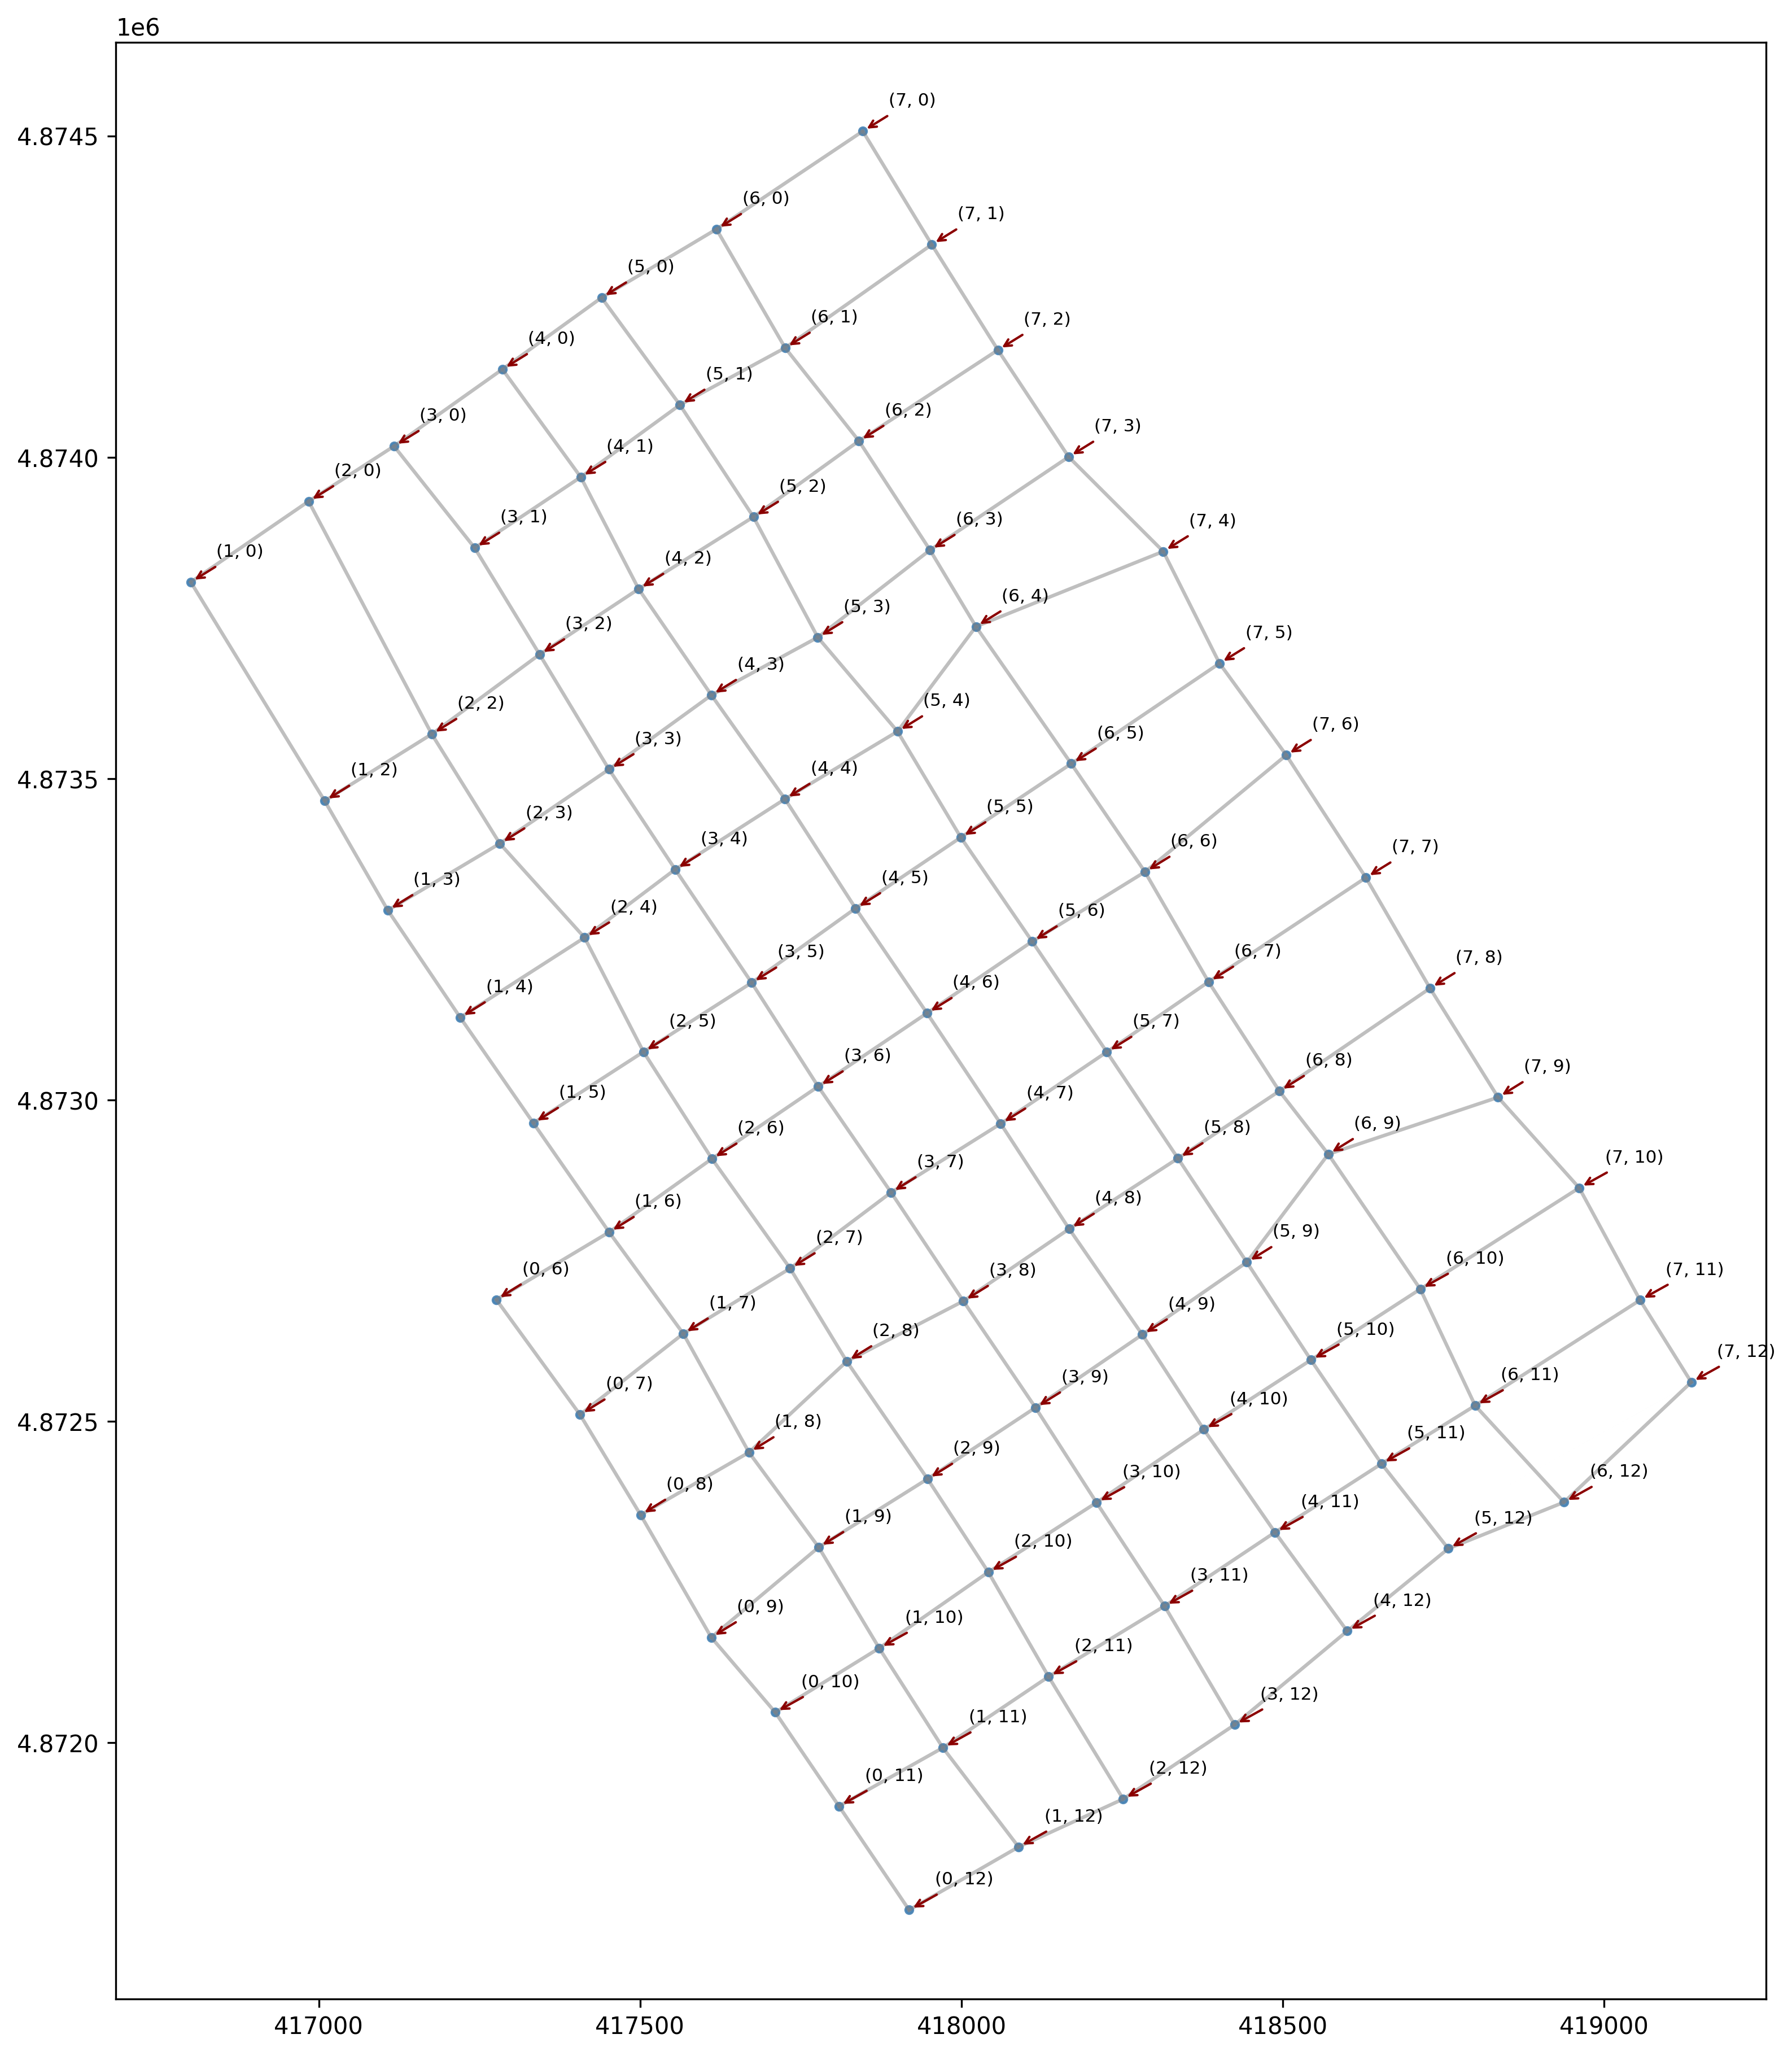

In [12]:
nearest_grids = fg.calculate_nearest_location(transformed_points, grids_i_axes, grids_j_axes)

plt.figure(figsize=(15, 15),dpi=300)
plt.gca().set_aspect('equal')
plt.scatter(points[:,0], points[:,1], s=10, c='steelblue', alpha=0.9)
bias_dist = 40
for i,(px,py) in enumerate(points):

    nearest_grid_idx = nearest_grids[i]
    gx,gy = nearest_grid_idx[0],nearest_grid_idx[1]

    plt.annotate(f'({gx}, {gy})',
                 xy=(px, py), 
                 xytext=(px+bias_dist, py+bias_dist),
                 arrowprops=dict(arrowstyle='->', color='darkred'),
                 fontsize=7.5,
                 zorder =3)

unique_grids_i = np.unique(nearest_grids[:, 0])
for i in unique_grids_i:

    indices = np.where(nearest_grids[:, 0] == i)[0]

    filter_col = nearest_grids[indices,1]

    sorted_indices = indices[np.argsort(filter_col)]
    selected_points = points[sorted_indices, :]

    plt.plot(selected_points[:,0], selected_points[:,1], c="gray", alpha=0.5, zorder=1)

unique_grids_j = np.unique(nearest_grids[:,1])

for j in unique_grids_j:

    indices = np.where(nearest_grids[:,1]==j)[0]

    filter_row = nearest_grids[indices, 0]

    sorted_indices = indices[np.argsort(filter_row)]
    
    selected_points = points[sorted_indices,:]
    plt.plot(selected_points[:,0], selected_points[:,1], c="gray", alpha=0.5, zorder=1)

#### 8. 优化第7步
- 8.1 取$\mathbf{i}'$轴上的峰值按从大到小的顺序构成列向量$I^*$，取$\mathbf{j}'$轴上的峰值从大到小的顺序构成列向量$J^*$。


- 8.2 获取相应最小值的位置$(r^*,s^*)$
$$
r^* = 
\arg\min_{r}(I^*-x')=
\arg\min_{r}[(p^*_{i,1}-x'),(p^*_{i,2}-x'),\cdots,(p^*_{i,n}-x')]^T 
$$
$$
s^* = 
\arg\min_{s}(J^*-x')=
\arg\min_{s}[(p^*_{j,1}-x'),(q^*_{j,2}-x'),\cdots,(p^*_{j,n}-x')]^T
$$
- 8.3 对每个点进行上述操作，将获得的位置存入列表中$List=[\cdots,(r^*,s^*),\cdots]$，下面进行循环操作。


- 8.4 对这个列表进行查重，找出其中的重复项，比较这两个重复项这所对应的点$(X'_1,Y'_1)$、$(X'_2,Y'_2)$哪个距离$I'$轴更远。


- 8.5 计算更远的那个点（这里假设是$(X'_1,Y'_1)$,其位置为$(r^*_1,s^*_1)$）到临近两个位置$(r^*_1+1,s^*_1)$、$(r^*_1,s^*_1+1)$所对应的峰值矩阵的元素值的欧氏距离，取欧式距离最小的那个位置为该点的新位置。


- 8.6 重复8-4、8-5，直至所有点的位置都不冲突，停止循环，此时的$List$即结果。

#### 扩展
- 式子左边 右乘A的逆
$$			
\begin{bmatrix} x \quad y \end{bmatrix}
\underbrace{\begin{bmatrix}  
\cos\theta_1 & \sin\theta_1 \\  
\cos\theta_2 & \sin\theta_2  
\end{bmatrix}}_{A^{-1}}
\begin{array} {c}^{-1}\\ \\\end{array}
=
\begin{bmatrix} x' \quad y' \end{bmatrix}  
$$
- 扩展至所有点
$$			
\begin{bmatrix} 
x_1 \quad y_1 \\
x_2 \quad y_2 \\
\vdots \quad \vdots \\
x_n \quad y_n \\
\end{bmatrix}
\underbrace{\begin{bmatrix}  
\cos\theta_1 & \sin\theta_1 \\  
\cos\theta_2 & \sin\theta_2  
\end{bmatrix}}_{A^{-1}}
\begin{array} {c}^{-1}\\ \\\end{array}
=
\begin{bmatrix} 
x'_1 \quad y'_1 \\
x'_2 \quad y'_2 \\
\vdots \quad \vdots\\
x'_n \quad y'_n
\end{bmatrix}  
$$


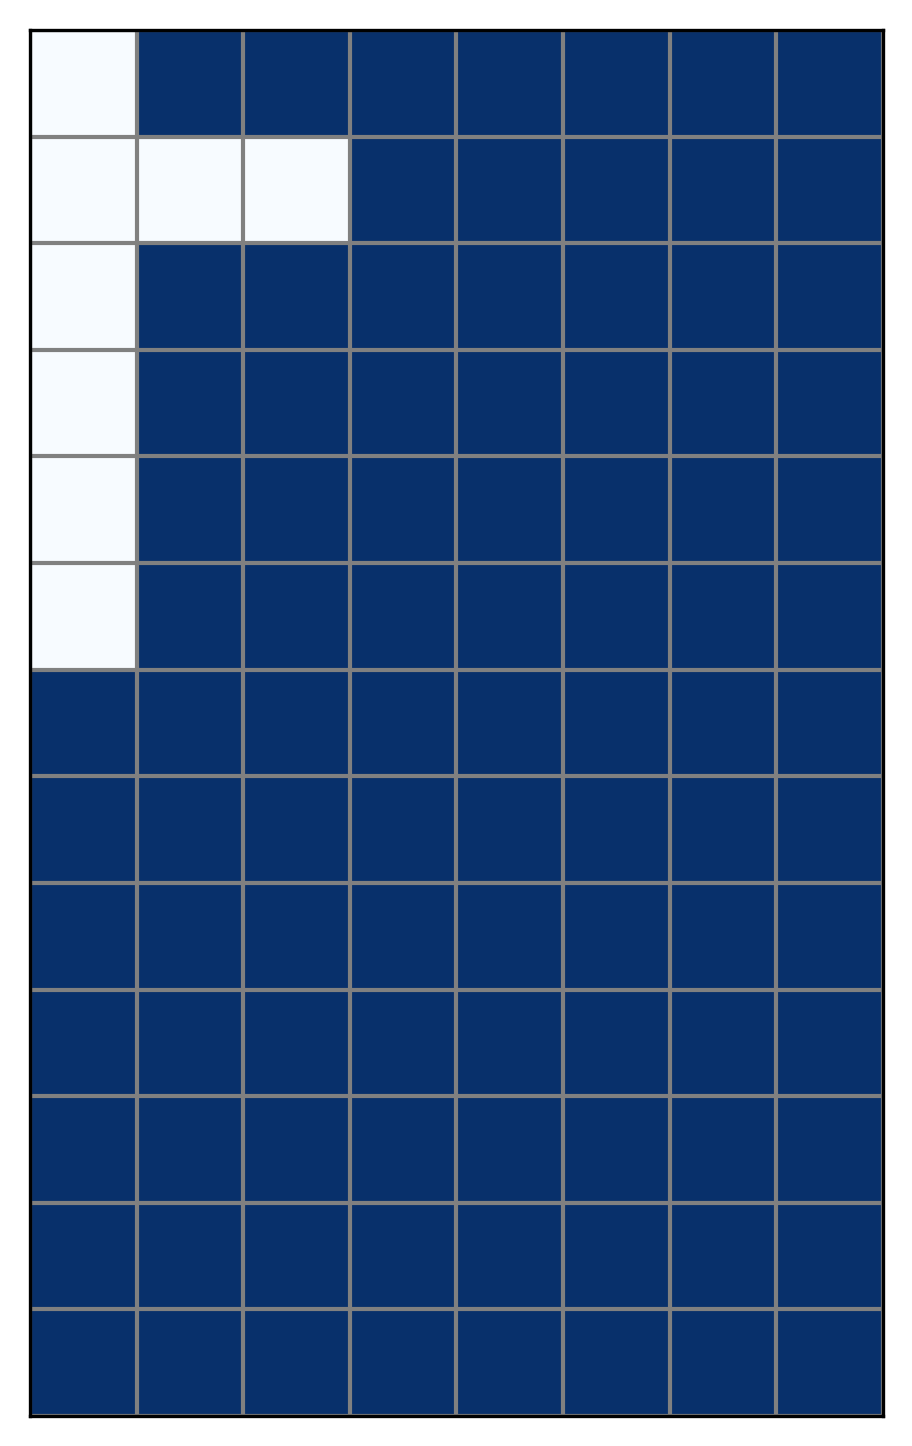

In [13]:
rows = len(grids_i_axes)
cols = len(grids_j_axes)


# 生成棋盘格
grid = np.zeros((cols,rows))
for (loc_r,loc_c) in nearest_grids:
    grid[loc_c,loc_r] = 1

fig, ax = plt.subplots(figsize=(6, 6),dpi=300)
ax.imshow(grid, cmap="Blues", interpolation="none")

# 加网格线
for i in range(cols + 1):
    ax.axhline(i - 0.5, color="grey", linewidth=1)
for j in range(rows + 1):
    ax.axvline(j - 0.5, color="grey", linewidth=1)

ax.set_xticks([])
ax.set_yticks([])
plt.show()

- 构建钻孔数据结构


    1. 钻孔数据结构中，地层的数据类型为数组，数组列名为

        ```
        ["strata_name", "underneath_strata", "above_strata", "lower_height", "upper_height"]
        ```

- 构建地层模型
    1. 先unique出一个地层列表。分层统计这些地层中的大地层，统计占优
    
    2. 以大层为界分割地层。验证空间分布。